# Plots the diurnal cycle of MCS initiation and mature stage frequency for multiple trackers over ocean & land
## The MCS track statistics data is produced by:
- /src/make_mcs_stats_from_maskfile.py

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import copy
import seaborn as sns
from sklearn.neighbors import KernelDensity
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import shapely.geometry as sgeom
from scipy import fftpack
import warnings
%matplotlib inline

In [2]:
PHASE = 'Summer'
# PHASE = 'Winter'

lifetime_bounds = [2,100]
region = 'tropics'
# Min number of MCS to plot
min_ntracks = 20

# PF land fraction threshold to separate land vs. ocean MCS
land_frac_thresh = 0.7
ocean_frac_thresh = 0.1

if PHASE == 'Summer':
    track_period = '20160810_20160910'
    datetime_range = pd.to_datetime(['2016-08-10T00', '2016-09-11T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-15, 30]
if PHASE == 'Winter':
    track_period = '20200201_20200301'
    datetime_range = pd.to_datetime(['2020-02-01T00', '2020-03-01T00'])
    lon_bounds = [-180, 180]
    lat_bounds = [-20, 15]
bounds = [lon_bounds[0], lon_bounds[1], lat_bounds[0], lat_bounds[1]]

rootdir = f'/pscratch/sd/f/feng045/DYAMOND/mcs_stats/{PHASE}/'
dir_PyFLEXTRKR = f'{rootdir}PyFLEXTRKR/'
dir_MOAAP = f'{rootdir}MOAAP/'
dir_TOOCAN = f'{rootdir}TOOCAN/'
dir_tobac = f'{rootdir}tobac/'
dir_TAMS = f'{rootdir}TAMS/'
dir_simpleTrack = f'{rootdir}simpleTrack/'
dir_DL = f'{rootdir}DL/'
dir_KFyAO = f'{rootdir}KFyAO/'

if PHASE == 'Summer':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'FV3',
        'm12': 'SCREAMv1',
    }

if PHASE == 'Winter':
    name_map = {
        'obs': 'OBS',
        'm1': 'ARPEGE',
        'm2': 'IFS',
        'm3': 'MPAS',
        # 'm4': 'NICAM',
        'm5': 'SAM',
        'm6': 'UM',
        'm7': 'GRIST',
        'm8': 'SCREAM',
        'm9': 'XSHiELD',
        'm10': 'GEOS',
        'm11': 'ICON',
        'm12': 'SCREAMv1',
    }

# Input filenames
filenames_PyFLEXTRKR = {key:f'{dir_PyFLEXTRKR}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_MOAAP = {key:f'{dir_MOAAP}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TOOCAN = {key:f'{dir_TOOCAN}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_tobac = {key:f'{dir_tobac}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_TAMS = {key:f'{dir_TAMS}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_simpleTrack = {key:f'{dir_simpleTrack}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_DL = {key:f'{dir_DL}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}
filenames_KFyAO = {key:f'{dir_KFyAO}mcs_stats_{PHASE}_{value}.nc' for key,value in name_map.items()}

figdir = f'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/{PHASE}/figures/MCSMIP/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/


## Check if input files exist

In [3]:
for key, value in filenames_PyFLEXTRKR.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/PyFLEXTRKR/mcs_stats_Summer_SCREAMv1.nc: True


In [4]:
for key, value in filenames_MOAAP.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/MOAAP/mcs_stats_Summer_SCREAMv1.nc: True


In [5]:
for key, value in filenames_TOOCAN.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TOOCAN/mcs_stats_Summer_SCREAMv1.nc: True


In [6]:
for key, value in filenames_tobac.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/tobac/mcs_stats_Summer_SCREAMv1.nc: True


In [7]:
for key, value in filenames_TAMS.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/TAMS/mcs_stats_Summer_SCREAMv1.nc: True


In [8]:
for key, value in filenames_simpleTrack.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/simpleTrack/mcs_stats_Summer_SCREAMv1.nc: True


In [9]:
for key, value in filenames_DL.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/DL/mcs_stats_Summer_SCREAMv1.nc: True


In [10]:
for key, value in filenames_KFyAO.items():
    print(f'{value}: {os.path.isfile(value)}')

/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_OBS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_ARPEGE.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_IFS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_MPAS.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_NICAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_SAM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_UM.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_FV3.nc: True
/pscratch/sd/f/feng045/DYAMOND/mcs_stats/Summer/KFyAO/mcs_stats_Summer_SCREAMv1.nc: True


## Show a map for the subset region

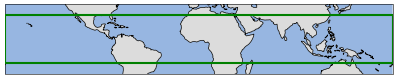

In [11]:
resolution = '110m'
# map_extent = [lon_bounds[0]-10,lon_bounds[1]+10,lat_bounds[0]-10,lat_bounds[1]+10]
map_extent = [lon_bounds[0],lon_bounds[1]-0.1,lat_bounds[0]-10,lat_bounds[1]+10]
land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
states = cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lakes', resolution)
proj = ccrs.PlateCarree(central_longitude=0)
box_proj = ccrs.PlateCarree(central_longitude=0)
fig = plt.figure(figsize=[10,10], dpi=50)
ax = plt.subplot(111, projection=proj)
ax.set_extent(map_extent, box_proj)
# Add land, coastlines, borders to inset
ax.add_feature(ocean, edgecolor='none', facecolor=cfeature.COLORS['water'])
ax.add_feature(land, facecolor='gainsboro', edgecolor='k')
# ax.add_feature(borders, edgecolor='k', facecolor='none')
# ax.add_feature(states, edgecolor='k', facecolor='none')
# Define the vertices of the rectangle in the projection coordinates
x1, y1 = proj.transform_point(lon_bounds[0], lat_bounds[0], proj)
x2, y2 = proj.transform_point(lon_bounds[1], lat_bounds[1], proj)
# Plot rectangle
ax.add_patch(mpl.patches.Rectangle((x1, y1), x2-x1, y2-y1, transform=proj, fill=None, lw=3, edgecolor='g', zorder=10))

In [12]:
# Read all files and combine them with a new dimension 'source'
ds_pyflex = xr.open_mfdataset(list(filenames_PyFLEXTRKR.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_pyflex['source'] = list(name_map.keys())
nsource = ds_pyflex.dims['source']
ds_pyflex

<xarray.Dataset>
Dimensions:                  (tracks: 5016, times: 600, nmaxpf: 3, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5012 5013 5014 5015
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5016), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5016), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5016), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5016, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5016, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5016, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5016, 600), meta=np.ndarray>
Attributes:
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon Oct 23 15:28:20 2023

In [13]:
# Read all files and combine them with a new dimension 'source'
ds_moaap = xr.open_mfdataset(list(filenames_MOAAP.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_moaap['source'] = list(name_map.keys())
ds_moaap

<xarray.Dataset>
Dimensions:                  (tracks: 5142, times: 600, nmaxpf: 3, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 5138 5139 5140 5141
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 5142), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5142), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 5142), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 5142, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5142, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 5142, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 5142, 600), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                MOAAP
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Apr 24 12:09:28 2024

In [14]:
# Read all files and combine them with a new dimension 'source'
ds_toocan = xr.open_mfdataset(list(filenames_TOOCAN.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_toocan['source'] = list(name_map.keys())
ds_toocan

<xarray.Dataset>
Dimensions:                  (tracks: 45171, times: 600, nmaxpf: 3, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 277349 277396 278054
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 45171), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 45171), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 45171), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 45171, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 45171, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 45171, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 45171, 600), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                TOOCAN
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri Nov  3 15:47:04 2023

In [15]:
# Read all files and combine them with a new dimension 'source'
ds_tobac = xr.open_mfdataset(list(filenames_tobac.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_tobac['source'] = list(name_map.keys())
ds_tobac

<xarray.Dataset>
Dimensions:                  (tracks: 36332, times: 600, nmaxpf: 3, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 2 3 6 ... 126662 126718 126729
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 36332), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 36332), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 36332), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 36332, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 36332, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 36332, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 36332, 600), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                tobac
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Fri May  3 20:38:43 2024

In [16]:
# Read all files and combine them with a new dimension 'source'
ds_tams = xr.open_mfdataset(list(filenames_TAMS.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_tams['source'] = list(name_map.keys())
ds_tams

<xarray.Dataset>
Dimensions:                  (tracks: 4575, times: 600, nmaxpf: 3, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4571 4572 4573 4574
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4575), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4575), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4575), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4575, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4575, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4575, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4575, 600), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                TAMS
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Dec 27 14:40:15 2023

In [17]:
# Read all files and combine them with a new dimension 'source'
ds_simtrack = xr.open_mfdataset(list(filenames_simpleTrack.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_simtrack['source'] = list(name_map.keys())
ds_simtrack

<xarray.Dataset>
Dimensions:                  (tracks: 22919, times: 600, nmaxpf: 3, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 442211 442501 444390
  * times                    (times) int64 0 1 2 3 4 5 ... 595 596 597 598 599
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 22919), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 22919), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 22919), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 22919, 600), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 600), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 600), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 22919, 600, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 22919, 600, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 600), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 600), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 600), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 22919, 600), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                simpleTrack
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed Jan  3 19:43:58 2024

In [18]:
# Read all files and combine them with a new dimension 'source'
ds_dl = xr.open_mfdataset(list(filenames_DL.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_dl['source'] = list(name_map.keys())
ds_dl

<xarray.Dataset>
Dimensions:                  (tracks: 4572, times: 1000, nmaxpf: 3, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 ... 11100 11110 11111 11115
  * times                    (times) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4572), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4572), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4572), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4572, 1000), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4572, 1000), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4572, 1000), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4572, 1000, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4572, 1000, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4572, 1000), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4572, 1000), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4572, 1000), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4572, 1000), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                DL
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Wed May 29 14:07:30 2024

In [19]:
# Read all files and combine them with a new dimension 'source'
ds_kfyao = xr.open_mfdataset(list(filenames_KFyAO.values()), combine='nested', concat_dim='source')
# Assign new coordinate 'source' using name_map dictionary keys
ds_kfyao['source'] = list(name_map.keys())
nsource = ds_kfyao.dims['source']
ds_kfyao

<xarray.Dataset>
Dimensions:                  (tracks: 4691, times: 1000, nmaxpf: 3, source: 9)
Coordinates:
  * tracks                   (tracks) int64 0 1 2 3 4 ... 4687 4688 4689 4690
  * times                    (times) int64 0 1 2 3 4 5 ... 995 996 997 998 999
  * nmaxpf                   (nmaxpf) int64 0 1 2
  * source                   (source) <U3 'obs' 'm1' 'm2' ... 'm6' 'm7' 'm12'
Data variables: (12/38)
    track_duration           (source, tracks) float64 dask.array<chunksize=(1, 4691), meta=np.ndarray>
    start_basetime           (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4691), meta=np.ndarray>
    end_basetime             (source, tracks) datetime64[ns] dask.array<chunksize=(1, 4691), meta=np.ndarray>
    base_time                (source, tracks, times) datetime64[ns] dask.array<chunksize=(1, 4691, 1000), meta=np.ndarray>
    core_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 1000), meta=np.ndarray>
    cold_area                (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 1000), meta=np.ndarray>
    ...                       ...
    pf_accumrain             (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4691, 1000, 3), meta=np.ndarray>
    pf_accumrainheavy        (source, tracks, times, nmaxpf) float32 dask.array<chunksize=(1, 4691, 1000, 3), meta=np.ndarray>
    pf_landfrac              (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 1000), meta=np.ndarray>
    total_rain               (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 1000), meta=np.ndarray>
    total_heavyrain          (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 1000), meta=np.ndarray>
    rainrate_heavyrain       (source, tracks, times) float32 dask.array<chunksize=(1, 4691, 1000), meta=np.ndarray>
Attributes:
    title:                  Summer OBS MCS statistics file
    tracker:                KFyAO
    pixel_radius_km:        10.0
    time_resolution_hour:   1.0
    tb_core_thresh:         225.0
    tb_cold_thresh:         241.0
    nmaxpf:                 3
    PF_rainrate_thresh:     2.0
    heavy_rainrate_thresh:  10.0
    landfrac_thresh:        [ 0 90]
    Created_on:             Mon May 20 12:24:56 2024

In [20]:
datetime_range, lon_bounds, lat_bounds, lifetime_bounds

(DatetimeIndex(['2016-08-10', '2016-09-11'], dtype='datetime64[ns]', freq=None),
 [-180, 180],
 [-15, 30],
 [2, 100])

In [21]:
ds_pyflex.attrs

{'pixel_radius_km': 10.0,
 'time_resolution_hour': 1.0,
 'tb_core_thresh': 225.0,
 'tb_cold_thresh': 241.0,
 'nmaxpf': 3,
 'PF_rainrate_thresh': 2.0,
 'heavy_rainrate_thresh': 10.0,
 'landfrac_thresh': array([ 0, 90]),
 'Created_on': 'Mon Oct 23 15:28:20 2023'}

In [22]:
# Get global attributes
pixel_radius = ds_pyflex.attrs['pixel_radius_km']
time_resolution = ds_pyflex.attrs['time_resolution_hour']

## Custom functions to subset tracks

In [23]:
def find_tracks_start(ds_in, load_data=False):
    """
    Find tracks within a period, region and lifetime bounds.
    """
    # Get the track start time, location, lifetime
    start_basetime = ds_in.start_basetime
    start_lon = ds_in.meanlon.isel(times=0)
    start_lat = ds_in.meanlat.isel(times=0)
    lifetime = ds_in.track_duration * ds_in.attrs['time_resolution_hour']
    
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False

    # Filter tracks that initiates within a time period, region and lifetime
    ds_out = ds_in.where(
        (start_basetime >= min(datetime_range)) & (start_basetime <= max(datetime_range)) & \
        (start_lon >= min(lon_bounds)) & (start_lon <= max(lon_bounds)) & \
        (start_lat >= min(lat_bounds)) & (start_lat <= max(lat_bounds)) & \
        (lifetime >= min(lifetime_bounds)) & (lifetime <= max(lifetime_bounds)),
        drop=drop_vars,
    )
    return ds_out

def get_land_ocean_ds(ds_in, load_data=False):
    """
    Separate land vs. ocean tracks in Datasets.
    """
    # Load data into memory
    if load_data:
        ds_in.load()
        drop_vars = True
    else:
        drop_vars = False
        
    # Calculate track land fraction
    # init_landfrac = ds_in.pf_landfrac.isel(times=slice(0,3)).mean(dim='times')
    avg_landfrac = ds_in.pf_landfrac.mean(dim='times')
    ds_l = ds_in.where(avg_landfrac > land_frac_thresh, drop=drop_vars)
    ds_o = ds_in.where(avg_landfrac < ocean_frac_thresh, drop=drop_vars)
    return (ds_l, ds_o)

## Filter tracks by time, region, lifetime

In [24]:
dss_pyflex = find_tracks_start(ds_pyflex, load_data=False)

In [25]:
dss_moaap = find_tracks_start(ds_moaap, load_data=False)

In [26]:
dss_toocan = find_tracks_start(ds_toocan, load_data=False)

In [27]:
dss_tobac = find_tracks_start(ds_tobac, load_data=False)

In [28]:
dss_tams = find_tracks_start(ds_tams, load_data=False)

In [29]:
dss_simtrack = find_tracks_start(ds_simtrack, load_data=False)

In [30]:
dss_dl = find_tracks_start(ds_dl, load_data=False)

In [31]:
dss_kfyao = find_tracks_start(ds_kfyao, load_data=False)

In [32]:
print(f'Number of MCS (PyFLEXTRKR)')
for key in dss_pyflex['source'].data:
    ntracks = np.count_nonzero(dss_pyflex.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (PyFLEXTRKR)
OBS: 2521
ARPEGE: 776
IFS: 2418
MPAS: 1200
NICAM: 2776
SAM: 2644
UM: 1603
FV3: 2054
SCREAMv1: 2701


In [33]:
print(f'Number of MCS (MOAAP)')
for key in dss_moaap['source'].data:
    ntracks = np.count_nonzero(dss_moaap.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (MOAAP)
OBS: 2649
ARPEGE: 538
IFS: 2754
MPAS: 1393
NICAM: 2154
SAM: 2229
UM: 1871
FV3: 2181
SCREAMv1: 2846


In [34]:
print(f'Number of MCS (TOOCAN)')
for key in dss_toocan['source'].data:
    ntracks = np.count_nonzero(dss_toocan.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TOOCAN)
OBS: 3830
ARPEGE: 608
IFS: 4758
MPAS: 1276
NICAM: 3745
SAM: 2451
UM: 2190
FV3: 3063
SCREAMv1: 5316


In [35]:
print(f'Number of MCS (tobac)')
for key in dss_tobac['source'].data:
    ntracks = np.count_nonzero(dss_tobac.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (tobac)
OBS: 3071
ARPEGE: 1037
IFS: 4023
MPAS: 1236
NICAM: 4310
SAM: 3628
UM: 2543
FV3: 3018
SCREAMv1: 4001


In [36]:
print(f'Number of MCS (TAMS)')
for key in dss_tams['source'].data:
    ntracks = np.count_nonzero(dss_tams.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (TAMS)
OBS: 2095
ARPEGE: 889
IFS: 2767
MPAS: 796
NICAM: 2435
SAM: 3402
UM: 1667
FV3: 2383
SCREAMv1: 2839


In [37]:
print(f'Number of MCS (simpleTrack)')
for key in dss_simtrack['source'].data:
    ntracks = np.count_nonzero(dss_simtrack.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (simpleTrack)
OBS: 2405
ARPEGE: 1029
IFS: 2590
MPAS: 995
NICAM: 2599
SAM: 3065
UM: 1475
FV3: 2257
SCREAMv1: 2628


In [38]:
print(f'Number of MCS (DL)')
for key in dss_dl['source'].data:
    ntracks = np.count_nonzero(dss_dl.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (DL)
OBS: 1621
ARPEGE: 573
IFS: 1003
MPAS: 461
NICAM: 888
SAM: 955
UM: 833
FV3: 920
SCREAMv1: 817


In [39]:
print(f'Number of MCS (KFyAO)')
for key in dss_kfyao['source'].data:
    ntracks = np.count_nonzero(dss_kfyao.track_duration.sel(source=key) > 0)
    print(f'{name_map[key]}: {ntracks}')

Number of MCS (KFyAO)
OBS: 2025
ARPEGE: 810
IFS: 2503
MPAS: 1012
NICAM: 2367
SAM: 2807
UM: 1495
FV3: 2078
SCREAMv1: 2684


## Separate land vs. ocean MCS

In [40]:
dss_pyflex_l, dss_pyflex_o = get_land_ocean_ds(dss_pyflex, load_data=False)

In [41]:
dss_moaap_l, dss_moaap_o = get_land_ocean_ds(dss_moaap, load_data=False)

In [42]:
dss_toocan_l, dss_toocan_o = get_land_ocean_ds(dss_toocan, load_data=False)

In [43]:
dss_tobac_l, dss_tobac_o = get_land_ocean_ds(dss_tobac, load_data=False)

In [44]:
dss_tams_l, dss_tams_o = get_land_ocean_ds(dss_tams, load_data=False)

In [45]:
dss_simtrack_l, dss_simtrack_o = get_land_ocean_ds(dss_simtrack, load_data=False)

In [46]:
dss_dl_l, dss_dl_o = get_land_ocean_ds(dss_dl, load_data=False)

In [47]:
dss_kfyao_l, dss_kfyao_o = get_land_ocean_ds(dss_kfyao, load_data=False)

## Use a simple method to exclude possible split tracks
### If max CCS area occur within the first x% of a tracks start time: split

In [48]:
# Set max area time fraction thresholds (if max area occur between these times, the track is retained)
max_timefrac_thresh = [0.1, 0.9]

In [49]:
# Suppress RuntimeWarning messages
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_pyflex_o = dss_pyflex_o.ccs_area.idxmax(dim='times', skipna=True) / dss_pyflex_o.track_duration
maxccs_timefrac_pyflex_l = dss_pyflex_l.ccs_area.idxmax(dim='times', skipna=True) / dss_pyflex_l.track_duration
# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_pyflex_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_pyflex_l > min(max_timefrac_thresh)
# Apply non-split mask to the DataSets (i.e., set all variables of split tracks to NaN)
dss_pyflex_o = dss_pyflex_o.where(mask_nonsplit_o)
dss_pyflex_l = dss_pyflex_l.where(mask_nonsplit_l)

In [50]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_moaap_o = dss_moaap_o.ccs_area.idxmax(dim='times', skipna=True) / dss_moaap_o.track_duration
maxccs_timefrac_moaap_l = dss_moaap_l.ccs_area.idxmax(dim='times', skipna=True) / dss_moaap_l.track_duration
# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_moaap_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_moaap_l > min(max_timefrac_thresh)
# Apply non-split mask to the DataSets (i.e., set all variables of split tracks to NaN)
dss_moaap_o = dss_moaap_o.where(mask_nonsplit_o)
dss_moaap_l = dss_moaap_l.where(mask_nonsplit_l)

In [51]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_toocan_o = dss_toocan_o.ccs_area.idxmax(dim='times', skipna=True) / dss_toocan_o.track_duration
maxccs_timefrac_toocan_l = dss_toocan_l.ccs_area.idxmax(dim='times', skipna=True) / dss_toocan_l.track_duration
# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_toocan_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_toocan_l > min(max_timefrac_thresh)
# Apply non-split mask to the DataSets (i.e., set all variables of split tracks to NaN)
dss_toocan_o = dss_toocan_o.where(mask_nonsplit_o)
dss_toocan_l = dss_toocan_l.where(mask_nonsplit_l)

In [52]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_tobac_o = dss_tobac_o.ccs_area.idxmax(dim='times', skipna=True) / dss_tobac_o.track_duration
maxccs_timefrac_tobac_l = dss_tobac_l.ccs_area.idxmax(dim='times', skipna=True) / dss_tobac_l.track_duration
# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_tobac_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_tobac_l > min(max_timefrac_thresh)
# Apply non-split mask to the DataSets (i.e., set all variables of split tracks to NaN)
dss_tobac_o = dss_tobac_o.where(mask_nonsplit_o)
dss_tobac_l = dss_tobac_l.where(mask_nonsplit_l)

In [53]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_tams_o = dss_tams_o.ccs_area.idxmax(dim='times', skipna=True) / dss_tams_o.track_duration
maxccs_timefrac_tams_l = dss_tams_l.ccs_area.idxmax(dim='times', skipna=True) / dss_tams_l.track_duration
# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_tams_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_tams_l > min(max_timefrac_thresh)
# Apply non-split mask to the DataSets (i.e., set all variables of split tracks to NaN)
dss_tams_o = dss_tams_o.where(mask_nonsplit_o)
dss_tams_l = dss_tams_l.where(mask_nonsplit_l)

In [54]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_simtrack_o = dss_simtrack_o.ccs_area.idxmax(dim='times', skipna=True) / dss_simtrack_o.track_duration
maxccs_timefrac_simtrack_l = dss_simtrack_l.ccs_area.idxmax(dim='times', skipna=True) / dss_simtrack_l.track_duration
# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_simtrack_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_simtrack_l > min(max_timefrac_thresh)
# Apply non-split mask to the DataSets (i.e., set all variables of split tracks to NaN)
dss_simtrack_o = dss_simtrack_o.where(mask_nonsplit_o)
dss_simtrack_l = dss_simtrack_l.where(mask_nonsplit_l)

In [55]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_dl_o = dss_dl_o.ccs_area.idxmax(dim='times', skipna=True) / dss_dl_o.track_duration
maxccs_timefrac_dl_l = dss_dl_l.ccs_area.idxmax(dim='times', skipna=True) / dss_dl_l.track_duration
# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_dl_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_dl_l > min(max_timefrac_thresh)
# Apply non-split mask to the DataSets (i.e., set all variables of split tracks to NaN)
dss_dl_o = dss_dl_o.where(mask_nonsplit_o)
dss_dl_l = dss_dl_l.where(mask_nonsplit_l)

In [56]:
# Get the relative fraction in time (from 0 to 1) when CCS reaches maximum
# Time index when CCS area is maximum divide by the track duration
maxccs_timefrac_kfyao_o = dss_kfyao_o.ccs_area.idxmax(dim='times', skipna=True) / dss_kfyao_o.track_duration
maxccs_timefrac_kfyao_l = dss_kfyao_l.ccs_area.idxmax(dim='times', skipna=True) / dss_kfyao_l.track_duration
# Masks for non-split
mask_nonsplit_o = maxccs_timefrac_kfyao_o > min(max_timefrac_thresh)
mask_nonsplit_l = maxccs_timefrac_kfyao_l > min(max_timefrac_thresh)
# Apply non-split mask to the DataSets (i.e., set all variables of split tracks to NaN)
dss_kfyao_o = dss_kfyao_o.where(mask_nonsplit_o)
dss_kfyao_l = dss_kfyao_l.where(mask_nonsplit_l)

## Count the number of tracks for each source

In [57]:
# Get number of tracks for land vs. ocean
ntracks_pyflex_l = {}
ntracks_pyflex_o = {}
for key in dss_pyflex['source'].data:
    ntracks_pyflex_l[key] = np.count_nonzero(dss_pyflex_l.track_duration.sel(source=key) > 0)
    ntracks_pyflex_o[key] = np.count_nonzero(dss_pyflex_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_pyflex_l[ii]}')
print(f'Number of MCS - Land (PyFLEXTRKR): {ntracks_pyflex_l}')
print(f'Number of MCS - Ocean (PyFLEXTRKR): {ntracks_pyflex_o}')

Number of MCS - Land (PyFLEXTRKR): {'obs': 826, 'm1': 272, 'm2': 868, 'm3': 582, 'm4': 634, 'm5': 670, 'm6': 496, 'm7': 666, 'm12': 913}
Number of MCS - Ocean (PyFLEXTRKR): {'obs': 1140, 'm1': 325, 'm2': 1090, 'm3': 297, 'm4': 1513, 'm5': 1335, 'm6': 741, 'm7': 961, 'm12': 1248}


In [58]:
# Get number of tracks for land vs. ocean
ntracks_moaap_l = {}
ntracks_moaap_o = {}
for key in dss_moaap['source'].data:
    ntracks_moaap_l[key] = np.count_nonzero(dss_moaap_l.track_duration.sel(source=key) > 0)
    ntracks_moaap_o[key] = np.count_nonzero(dss_moaap_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_moaap_l[ii]}')
print(f'Number of MCS - Land (MOAAP): {ntracks_moaap_l}')
print(f'Number of MCS - Ocean (MOAAP): {ntracks_moaap_o}')

Number of MCS - Land (MOAAP): {'obs': 784, 'm1': 119, 'm2': 842, 'm3': 582, 'm4': 452, 'm5': 547, 'm6': 473, 'm7': 527, 'm12': 795}
Number of MCS - Ocean (MOAAP): {'obs': 1304, 'm1': 304, 'm2': 1441, 'm3': 461, 'm4': 1225, 'm5': 1261, 'm6': 982, 'm7': 1240, 'm12': 1578}


In [59]:
# Get number of tracks for land vs. ocean
ntracks_toocan_l = {}
ntracks_toocan_o = {}
for key in dss_toocan['source'].data:
    ntracks_toocan_l[key] = np.count_nonzero(dss_toocan_l.track_duration.sel(source=key) > 0)
    ntracks_toocan_o[key] = np.count_nonzero(dss_toocan_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_toocan_l[ii]}')
print(f'Number of MCS - Land (TOOCAN): {ntracks_toocan_l}')
print(f'Number of MCS - Ocean (TOOCAN): {ntracks_toocan_o}')

Number of MCS - Land (TOOCAN): {'obs': 1084, 'm1': 105, 'm2': 1548, 'm3': 491, 'm4': 893, 'm5': 808, 'm6': 458, 'm7': 752, 'm12': 1549}
Number of MCS - Ocean (TOOCAN): {'obs': 2319, 'm1': 458, 'm2': 2847, 'm3': 567, 'm4': 2380, 'm5': 1339, 'm6': 1491, 'm7': 1973, 'm12': 3373}


In [60]:
# Get number of tracks for land vs. ocean
ntracks_tobac_l = {}
ntracks_tobac_o = {}
for key in dss_tobac['source'].data:
    ntracks_tobac_l[key] = np.count_nonzero(dss_tobac_l.track_duration.sel(source=key) > 0)
    ntracks_tobac_o[key] = np.count_nonzero(dss_tobac_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_tobac_l[ii]}')
print(f'Number of MCS - Land (tobac): {ntracks_tobac_l}')
print(f'Number of MCS - Ocean (tobac): {ntracks_tobac_o}')

Number of MCS - Land (tobac): {'obs': 818, 'm1': 245, 'm2': 1164, 'm3': 437, 'm4': 848, 'm5': 905, 'm6': 626, 'm7': 733, 'm12': 1020}
Number of MCS - Ocean (tobac): {'obs': 1477, 'm1': 574, 'm2': 1936, 'm3': 393, 'm4': 2438, 'm5': 1842, 'm6': 1296, 'm7': 1538, 'm12': 1928}


In [61]:
# Get number of tracks for land vs. ocean
ntracks_tams_l = {}
ntracks_tams_o = {}
for key in dss_tams['source'].data:
    ntracks_tams_l[key] = np.count_nonzero(dss_tams_l.track_duration.sel(source=key) > 0)
    ntracks_tams_o[key] = np.count_nonzero(dss_tams_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_tams_l[ii]}')
print(f'Number of MCS - Land (TAMS): {ntracks_tams_l}')
print(f'Number of MCS - Ocean (TAMS): {ntracks_tams_o}')

Number of MCS - Land (TAMS): {'obs': 551, 'm1': 275, 'm2': 817, 'm3': 265, 'm4': 554, 'm5': 739, 'm6': 500, 'm7': 677, 'm12': 556}
Number of MCS - Ocean (TAMS): {'obs': 884, 'm1': 358, 'm2': 1262, 'm3': 184, 'm4': 1225, 'm5': 1564, 'm6': 718, 'm7': 1093, 'm12': 1258}


In [62]:
# Get number of tracks for land vs. ocean
ntracks_simtrack_l = {}
ntracks_simtrack_o = {}
for key in dss_simtrack['source'].data:
    ntracks_simtrack_l[key] = np.count_nonzero(dss_simtrack_l.track_duration.sel(source=key) > 0)
    ntracks_simtrack_o[key] = np.count_nonzero(dss_simtrack_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_simtrack_l[ii]}')
print(f'Number of MCS - Land (simpleTrack): {ntracks_simtrack_l}')
print(f'Number of MCS - Ocean (simpleTrack): {ntracks_simtrack_o}')

Number of MCS - Land (simpleTrack): {'obs': 817, 'm1': 366, 'm2': 898, 'm3': 320, 'm4': 654, 'm5': 784, 'm6': 464, 'm7': 739, 'm12': 722}
Number of MCS - Ocean (simpleTrack): {'obs': 1006, 'm1': 454, 'm2': 1208, 'm3': 302, 'm4': 1340, 'm5': 1504, 'm6': 678, 'm7': 1017, 'm12': 1266}


In [63]:
# Get number of tracks for land vs. ocean
ntracks_dl_l = {}
ntracks_dl_o = {}
for key in dss_dl['source'].data:
    ntracks_dl_l[key] = np.count_nonzero(dss_dl_l.track_duration.sel(source=key) > 0)
    ntracks_dl_o[key] = np.count_nonzero(dss_dl_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_dl_l[ii]}')
print(f'Number of MCS - Land (DL): {ntracks_dl_l}')
print(f'Number of MCS - Ocean (DL): {ntracks_dl_o}')

Number of MCS - Land (DL): {'obs': 410, 'm1': 229, 'm2': 399, 'm3': 191, 'm4': 329, 'm5': 310, 'm6': 318, 'm7': 373, 'm12': 247}
Number of MCS - Ocean (DL): {'obs': 620, 'm1': 235, 'm2': 422, 'm3': 193, 'm4': 409, 'm5': 451, 'm6': 390, 'm7': 398, 'm12': 377}


In [64]:
# Get number of tracks for land vs. ocean
ntracks_kfyao_l = {}
ntracks_kfyao_o = {}
for key in dss_kfyao['source'].data:
    ntracks_kfyao_l[key] = np.count_nonzero(dss_kfyao_l.track_duration.sel(source=key) > 0)
    ntracks_kfyao_o[key] = np.count_nonzero(dss_kfyao_o.track_duration.sel(source=key) > 0)
    # print(f'{name_map[key]}: {ntracks_kfyao_l[ii]}')
print(f'Number of MCS - Land (KFyAO): {ntracks_kfyao_l}')
print(f'Number of MCS - Ocean (KFyAO): {ntracks_kfyao_o}')

Number of MCS - Land (KFyAO): {'obs': 637, 'm1': 257, 'm2': 789, 'm3': 392, 'm4': 547, 'm5': 678, 'm6': 448, 'm7': 626, 'm12': 705}
Number of MCS - Ocean (KFyAO): {'obs': 932, 'm1': 384, 'm2': 1248, 'm3': 278, 'm4': 1290, 'm5': 1466, 'm6': 725, 'm7': 984, 'm12': 1370}


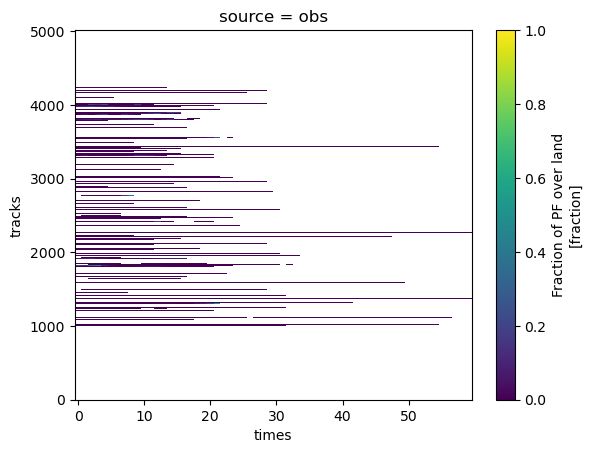

In [65]:
dss_pyflex_o.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

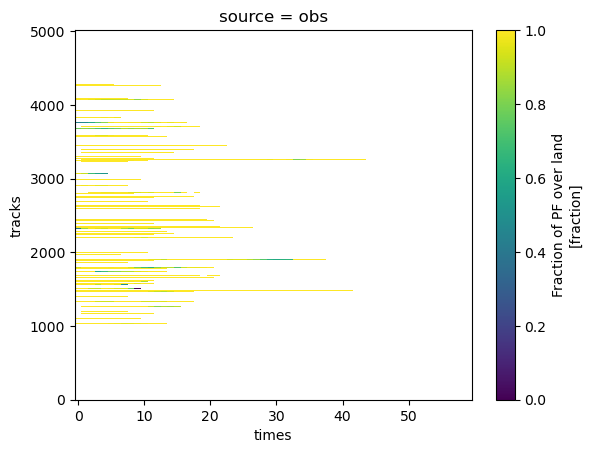

In [66]:
dss_pyflex_l.pf_landfrac.sel(source='obs').isel(times=slice(0,60)).plot()

## Functions for diurnal cycle analysis

In [67]:
def utc2lt(UTC, lon):
    """
    A simple function to convert UTC time to local solar time for a given longitude.
    
    Arguments:
       UTC: array-like
           Time in UTC.
       lon: array-like
           Longitude in degrees.
           
    Returns:
       localtime: array-like
           Local solar time.
    """
    
    # Hour per degree longitude 
    hourperdeg = 24./360.
    # Convert to local time
    localtime = UTC + lon * hourperdeg
    
    # Adjust time
    if np.count_nonzero(localtime >= 24) > 0:
        localtime[localtime >= 24] -= 24
    
    if np.count_nonzero(localtime < 0) > 0:
        localtime[localtime < 0] += 24

    return localtime

def harmonic_phase_amplitude(var, nharm, hr1, binsize=1.0):
    """
    Calculates the harmonic phase and amplitude for the requested number
    of harmonics. The phase indicates the location of the peak closest to
    T=0 for each harmonic along the T-axis--it can be on either side of 0.
    
    Arguments:
       var   = array to be analyzed, XT ordering assumed.
       nharm = number of harmonics to calculate
       hr1   = hour of the first time in the time series--used to adj. phase to be 0 at 0 hrs
       binsize = size of the hour bin for calculating phase. default=1.0
       
    Returns:
       amp[nharm] = amplitude of each harmonic
       phs[nharm] = phase of each harmonic, with 0 phase set to hour 0
       pvar[nharm] = percent variance explained
    Created: William.Gustafson@pnnl.gov, 17-Jan-2014
    Last modified: William.Gustafson@pnnl.gov, 22-Jan-2014
    Modified by: Zhe.Feng@pnnl.gov, 10-Jan-2019
    """
    nt = var.shape[-1]
#     w = float(nt) / (2.*np.arccos(-1.))
    w = float(nt) * binsize / (2.*np.arccos(-1.))
    ft = fftpack.fft(var, axis=-1)

    # 0th index returned by fft is the trend, so harmonics start at 1
    ampall = np.abs(ft)[1:] * 2./float(nt)  # need all amplitudes to get total variance
    amp = ampall[0:nharm]
    phs = np.angle(ft)[1:nharm+1]
#     phs = np.angle(ft)[1:nharm+1] * binsize

    totvar = 0.5*np.sum(ampall*ampall)  # total variance
    zeros = np.where(totvar < 1e-12, True, False)  # Need to mask out zero variance values for getting percent values
    totvar_nozeros = np.where(zeros, 1., totvar)
    pvar = np.empty_like(amp)

    for n in range(nharm):
        np1 = n + 1  # adjust by one to get the harmonic number vs. its index
#         phs_offset_max = float(nt)/float(np1)  # max possible phase offset for this harmonic
        phs_offset_max = float(nt) * binsize / float(np1)  # max possible phase offset for this harmonic

        # Have to switch rotation direction of the phase angle to get
        # where first peak occurs. We want it to indicate the angle where
        # the peak occurs. We also do the shift here for the offset due
        # to the first hour not being at 0 (what was sent into this routine).
        phs[n] = phs_offset_max - phs[n] * w / float(np1) + hr1

        # Now, we adjust for a phase that might be a multiple of the given harmonic.
        phs[n] = np.where(phs[n]>phs_offset_max, phs[n]-phs_offset_max, phs[n])
        phs[n] = np.where(phs[n]<0, phs[n] + float(nt)*binsize/float(np1), phs[n])

        # Get percent variance explained by each harmonic.
        pvar[n] = np.where(zeros, 0., 100.*(0.5*amp[n]*amp[n])/totvar_nozeros)
    
    return amp, phs, pvar

In [68]:
def get_mcs_diurnal_hours(ds, binhour, mcs_status, ntracks):
    """
    Get MCS diurnal hour PDF in local time.
    """
    nsource = ds.dims['source']
    nbins = len(binhour)-1
    
    # Get base time (UTC)
    base_time = ds.base_time.load()
    # Convert base time to fractional hour
    hourUTC = base_time.dt.hour + (base_time.dt.minute / 60)
    # Convert longitudes from -180~+180 to 0~360
    if (ds.meanlon.min().data < 0):
        meanlon = ds.meanlon.load().data % 360
    else:
        meanlon = ds.meanlon.load().data
    # Convert UTC time to local time
    hourLT = utc2lt(hourUTC.data, meanlon)
    # Convert to DataArray for convenience
    hourLT = xr.DataArray(hourLT, coords={'source':ds.source, 'tracks':ds.tracks, 'times':ds.times}, dims=('source','tracks','times'))
    
    binrange = (np.min(binhour), np.max(binhour))

    # pdf_inithour = np.full((nsource, nbins), np.NaN, dtype=float)
    # pdf_mcshour = np.full((nsource, nbins), np.NaN, dtype=float)
    fillvals = np.full(nbins, np.NaN, dtype=float)
    pdf_inithour = {src: fillvals for src in name_map.keys()}
    pdf_mcshour = {src: fillvals for src in name_map.keys()}
    # Loop over each source in the DataSet
    for i, src in enumerate(ds['source'].data):
        if ntracks[src] > min_ntracks:
            # MCS initiation hours histogram
            pdf_inithour[src], bins = np.histogram(hourLT.isel(times=0).sel(source=src), bins=binhour, range=binrange, density=True)
            # MCS stage hours histogram
            pdf_mcshour[src], bins = np.histogram(hourLT.where(mcs_status == 1).sel(source=src), bins=binhour, range=binrange, density=True)
    
    return pdf_inithour, pdf_mcshour

In [69]:
# Thresholds to define MCS mature stage
# heavy_rainrate_thresh = dss_pyflex.attrs['heavy_rainrate_thresh']
# mcs_min_rainvol_thresh = 20000.   # [km^2 mm/h] Min rain volume threshold
mcs_min_ccsarea_thresh = 40000.   # [km^2] Min CCS area threshold
pf_majoraxis_thresh = 100.   # [km] MCS PF major axis length threshold

# Get variables needed to define MCS mature stage
# pf_volrain_pyflex = dss_pyflex.total_rain * pixel_radius**2
# pf_maxrainrate_pyflex = dss_pyflex.pf_maxrainrate.isel(nmaxpf=0)
ccsarea_pyflex = dss_pyflex.ccs_area
pf_majoraxis_pyflex = dss_pyflex.pf_majoraxis

# In PyFLEXTRKR SAAG robust MCS code (robustmcspf_saag.py)
# Both the max rain rate & rain volume must exceed these thresholds & persist for >= 4 hours to be labeled MCS period
# This is a simplified version (ignore time continuity requirement)
# pf_mcsstatus_pyflex = (pf_maxrainrate_pyflex > heavy_rainrate_thresh) & (pf_volrain_pyflex > mcs_min_rainvol_thresh)

# Simple PF major axis length criteria
pf_mcsstatus_pyflex = pf_majoraxis_pyflex > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_pyflex = ccsarea_pyflex > mcs_min_ccsarea_thresh

In [70]:
# Get variables needed to define MCS mature stage
ccsarea_moaap = dss_moaap.ccs_area
pf_majoraxis_moaap = dss_moaap.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_moaap = pf_majoraxis_moaap > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_moaap = ccsarea_moaap > mcs_min_ccsarea_thresh

In [71]:
# Get variables needed to define MCS mature stage
ccsarea_toocan = dss_toocan.ccs_area
pf_majoraxis_toocan = dss_toocan.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_toocan = pf_majoraxis_toocan > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_toocan = ccsarea_toocan > mcs_min_ccsarea_thresh

In [72]:
# Get variables needed to define MCS mature stage
ccsarea_tobac = dss_tobac.ccs_area
pf_majoraxis_tobac = dss_tobac.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_tobac = pf_majoraxis_tobac > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_tobac = ccsarea_tobac > mcs_min_ccsarea_thresh

In [73]:
# Get variables needed to define MCS mature stage
ccsarea_tams = dss_tams.ccs_area
pf_majoraxis_tams = dss_tams.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_tams = pf_majoraxis_tams > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_tams = ccsarea_tams > mcs_min_ccsarea_thresh

In [74]:
# Get variables needed to define MCS mature stage
ccsarea_simtrack = dss_simtrack.ccs_area
pf_majoraxis_simtrack = dss_simtrack.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_simtrack = pf_majoraxis_simtrack > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_simtrack = ccsarea_simtrack > mcs_min_ccsarea_thresh

In [75]:
# Get variables needed to define MCS mature stage
ccsarea_dl = dss_dl.ccs_area
pf_majoraxis_dl = dss_dl.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_dl = pf_majoraxis_dl > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_dl = ccsarea_dl > mcs_min_ccsarea_thresh

In [76]:
# Get variables needed to define MCS mature stage
ccsarea_kfyao = dss_kfyao.ccs_area
pf_majoraxis_kfyao = dss_kfyao.pf_majoraxis

# Simple PF major axis length criteria
pf_mcsstatus_kfyao = pf_majoraxis_kfyao > pf_majoraxis_thresh

# Simple CCS area criteria
ccs_mcsstatus_kfyao = ccsarea_kfyao > mcs_min_ccsarea_thresh

## Calculate diurnal cycle (histogram of MCS time in LT)

In [77]:
# Set up diurnal hour bins
binhour = np.arange(0, 24.1, 2)
binhour_v = binhour[:-1] + np.diff(binhour)/2

In [78]:
# pdf_inithour_pyflex_l, pdf_mcshour_pyflex_l = get_mcs_diurnal_hours(dss_pyflex_l, binhour, ccs_mcsstatus_pyflex, ntracks_pyflex_l)
pdf_inithour_pyflex_l, pdf_mcshour_pyflex_l = get_mcs_diurnal_hours(dss_pyflex_l, binhour, pf_mcsstatus_pyflex, ntracks_pyflex_l)

# pdf_inithour_pyflex_o, pdf_mcshour_pyflex_o = get_mcs_diurnal_hours(dss_pyflex_o, binhour, ccs_mcsstatus_pyflex, ntracks_pyflex_o)
pdf_inithour_pyflex_o, pdf_mcshour_pyflex_o = get_mcs_diurnal_hours(dss_pyflex_o, binhour, pf_mcsstatus_pyflex, ntracks_pyflex_o)

In [79]:
pdf_inithour_moaap_l, pdf_mcshour_moaap_l = get_mcs_diurnal_hours(dss_moaap_l, binhour, pf_mcsstatus_moaap, ntracks_moaap_l)

pdf_inithour_moaap_o, pdf_mcshour_moaap_o = get_mcs_diurnal_hours(dss_moaap_o, binhour, pf_mcsstatus_moaap, ntracks_moaap_o)

In [80]:
pdf_inithour_toocan_l, pdf_mcshour_toocan_l = get_mcs_diurnal_hours(dss_toocan_l, binhour, pf_mcsstatus_toocan, ntracks_toocan_l)

pdf_inithour_toocan_o, pdf_mcshour_toocan_o = get_mcs_diurnal_hours(dss_toocan_o, binhour, pf_mcsstatus_toocan, ntracks_toocan_o)

In [81]:
pdf_inithour_tobac_l, pdf_mcshour_tobac_l = get_mcs_diurnal_hours(dss_tobac_l, binhour, pf_mcsstatus_tobac, ntracks_tobac_l)

pdf_inithour_tobac_o, pdf_mcshour_tobac_o = get_mcs_diurnal_hours(dss_tobac_o, binhour, pf_mcsstatus_tobac, ntracks_tobac_o)

In [82]:
pdf_inithour_tams_l, pdf_mcshour_tams_l = get_mcs_diurnal_hours(dss_tams_l, binhour, pf_mcsstatus_tams, ntracks_tams_l)

pdf_inithour_tams_o, pdf_mcshour_tams_o = get_mcs_diurnal_hours(dss_tams_o, binhour, pf_mcsstatus_tams, ntracks_tams_o)

In [83]:
pdf_inithour_simtrack_l, pdf_mcshour_simtrack_l = get_mcs_diurnal_hours(dss_simtrack_l, binhour, pf_mcsstatus_simtrack, ntracks_simtrack_l)

pdf_inithour_simtrack_o, pdf_mcshour_simtrack_o = get_mcs_diurnal_hours(dss_simtrack_o, binhour, pf_mcsstatus_simtrack, ntracks_simtrack_o)

In [84]:
pdf_inithour_dl_l, pdf_mcshour_dl_l = get_mcs_diurnal_hours(dss_dl_l, binhour, pf_mcsstatus_dl, ntracks_dl_l)

pdf_inithour_dl_o, pdf_mcshour_dl_o = get_mcs_diurnal_hours(dss_dl_o, binhour, pf_mcsstatus_dl, ntracks_dl_o)

In [85]:
pdf_inithour_kfyao_l, pdf_mcshour_kfyao_l = get_mcs_diurnal_hours(dss_kfyao_l, binhour, pf_mcsstatus_kfyao, ntracks_kfyao_l)

pdf_inithour_kfyao_o, pdf_mcshour_kfyao_o = get_mcs_diurnal_hours(dss_kfyao_o, binhour, pf_mcsstatus_kfyao, ntracks_kfyao_o)

### Get the min/max histogram value for each source & tracker
### This is useful to set a common limit for the diurnal cycle plots

In [86]:
# Concatenate all arrays into a single array, then get min/max values
all_values = np.concatenate(list(pdf_inithour_pyflex_l.values()))
minmax_inithour_pyflex_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_pyflex_l.values()))
minmax_mcshour_pyflex_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_inithour_pyflex_o.values()))
minmax_inithour_pyflex_o = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_pyflex_o.values()))
minmax_mcshour_pyflex_o = np.nanmin(all_values), np.nanmax(all_values)

In [87]:
# Concatenate all arrays into a single array, then get min/max values
all_values = np.concatenate(list(pdf_inithour_moaap_l.values()))
minmax_inithour_moaap_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_moaap_l.values()))
minmax_mcshour_moaap_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_inithour_moaap_o.values()))
minmax_inithour_moaap_o = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_moaap_o.values()))
minmax_mcshour_moaap_o = np.nanmin(all_values), np.nanmax(all_values)

In [88]:
# Concatenate all arrays into a single array, then get min/max values
all_values = np.concatenate(list(pdf_inithour_toocan_l.values()))
minmax_inithour_toocan_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_toocan_l.values()))
minmax_mcshour_toocan_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_inithour_toocan_o.values()))
minmax_inithour_toocan_o = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_toocan_o.values()))
minmax_mcshour_toocan_o = np.nanmin(all_values), np.nanmax(all_values)

In [89]:
# Concatenate all arrays into a single array, then get min/max values
all_values = np.concatenate(list(pdf_inithour_tobac_l.values()))
minmax_inithour_tobac_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_tobac_l.values()))
minmax_mcshour_tobac_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_inithour_tobac_o.values()))
minmax_inithour_tobac_o = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_tobac_o.values()))
minmax_mcshour_tobac_o = np.nanmin(all_values), np.nanmax(all_values)

In [90]:
# Concatenate all arrays into a single array, then get min/max values
all_values = np.concatenate(list(pdf_inithour_tams_l.values()))
minmax_inithour_tams_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_tams_l.values()))
minmax_mcshour_tams_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_inithour_tams_o.values()))
minmax_inithour_tams_o = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_tams_o.values()))
minmax_mcshour_tams_o = np.nanmin(all_values), np.nanmax(all_values)

In [91]:
# Concatenate all arrays into a single array, then get min/max values
all_values = np.concatenate(list(pdf_inithour_simtrack_l.values()))
minmax_inithour_simtrack_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_simtrack_l.values()))
minmax_mcshour_simtrack_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_inithour_simtrack_o.values()))
minmax_inithour_simtrack_o = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_simtrack_o.values()))
minmax_mcshour_simtrack_o = np.nanmin(all_values), np.nanmax(all_values)

In [92]:
# Concatenate all arrays into a single array, then get min/max values
all_values = np.concatenate(list(pdf_inithour_dl_l.values()))
minmax_inithour_dl_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_dl_l.values()))
minmax_mcshour_dl_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_inithour_dl_o.values()))
minmax_inithour_dl_o = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_dl_o.values()))
minmax_mcshour_dl_o = np.nanmin(all_values), np.nanmax(all_values)

In [93]:
# Concatenate all arrays into a single array, then get min/max values
all_values = np.concatenate(list(pdf_inithour_kfyao_l.values()))
minmax_inithour_kfyao_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_kfyao_l.values()))
minmax_mcshour_kfyao_l = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_inithour_kfyao_o.values()))
minmax_inithour_kfyao_o = np.nanmin(all_values), np.nanmax(all_values)

all_values = np.concatenate(list(pdf_mcshour_kfyao_o.values()))
minmax_mcshour_kfyao_o = np.nanmin(all_values), np.nanmax(all_values)

In [94]:
# Get min/max from all trackers
all_trackers_l = np.array([
    minmax_inithour_pyflex_l, 
    minmax_inithour_moaap_l,
    minmax_inithour_toocan_l,
    minmax_inithour_tobac_l,
    minmax_inithour_tams_l,
    minmax_inithour_simtrack_l,
    minmax_inithour_dl_l,
    minmax_inithour_kfyao_l,
])
minmax_inithour_l = np.nanmin(all_trackers_l), np.nanmax(all_trackers_l)

# Get min/max from all trackers
all_trackers_o = np.array([
    minmax_inithour_pyflex_o, 
    minmax_inithour_moaap_o,
    minmax_inithour_toocan_o,
    minmax_inithour_tobac_o,
    minmax_inithour_tams_o,
    minmax_inithour_simtrack_o,
    minmax_inithour_dl_o,
    minmax_inithour_kfyao_o,
])
minmax_inithour_o = np.nanmin(all_trackers_o), np.nanmax(all_trackers_o)

# Get min/max from all trackers
all_trackers_l = np.array([
    minmax_mcshour_pyflex_l, 
    minmax_mcshour_moaap_l,
    minmax_mcshour_toocan_l,
    minmax_mcshour_tobac_l,
    minmax_mcshour_tams_l,
    minmax_mcshour_simtrack_l,
    minmax_mcshour_dl_l,
    minmax_mcshour_kfyao_l,
])
minmax_mcshour_l = np.nanmin(all_trackers_l), np.nanmax(all_trackers_l)

# Get min/max from all trackers
all_trackers_o = np.array([
    minmax_mcshour_pyflex_o, 
    minmax_mcshour_moaap_o,
    minmax_mcshour_toocan_o,
    minmax_mcshour_tobac_o,
    minmax_mcshour_tams_o,
    minmax_mcshour_simtrack_o,
    minmax_mcshour_dl_o,
    minmax_mcshour_kfyao_o,
])
minmax_mcshour_o = np.nanmin(all_trackers_o), np.nanmax(all_trackers_o)

In [95]:
pdf_inithour_kfyao_l

{'obs': array([0.04474097, 0.03061224, 0.02197802, 0.01255887, 0.01177394,
        0.02119309, 0.05572998, 0.09733124, 0.08163265, 0.04395604,
        0.04317111, 0.03532182]),
 'm1': array([0.03307393, 0.03501946, 0.04085603, 0.03891051, 0.03307393,
        0.03501946, 0.04474708, 0.02918288, 0.03696498, 0.04863813,
        0.06809339, 0.05642023]),
 'm2': array([0.0278834 , 0.02534854, 0.02408112, 0.02217997, 0.01647655,
        0.01330798, 0.0278834 , 0.0608365 , 0.1121673 , 0.0842839 ,
        0.05386565, 0.03168568]),
 'm3': array([0.02423469, 0.01658163, 0.01785714, 0.01913265, 0.03188776,
        0.06122449, 0.09183673, 0.08545918, 0.03443878, 0.04209184,
        0.04209184, 0.03316327]),
 'm4': array([0.02559415, 0.02285192, 0.02193784, 0.01279707, 0.00914077,
        0.01371115, 0.01736746, 0.08318099, 0.14442413, 0.07952468,
        0.04204753, 0.0274223 ]),
 'm5': array([0.02507375, 0.0339233 , 0.01474926, 0.01622419, 0.01327434,
        0.02581121, 0.04941003, 0.07079646, 0

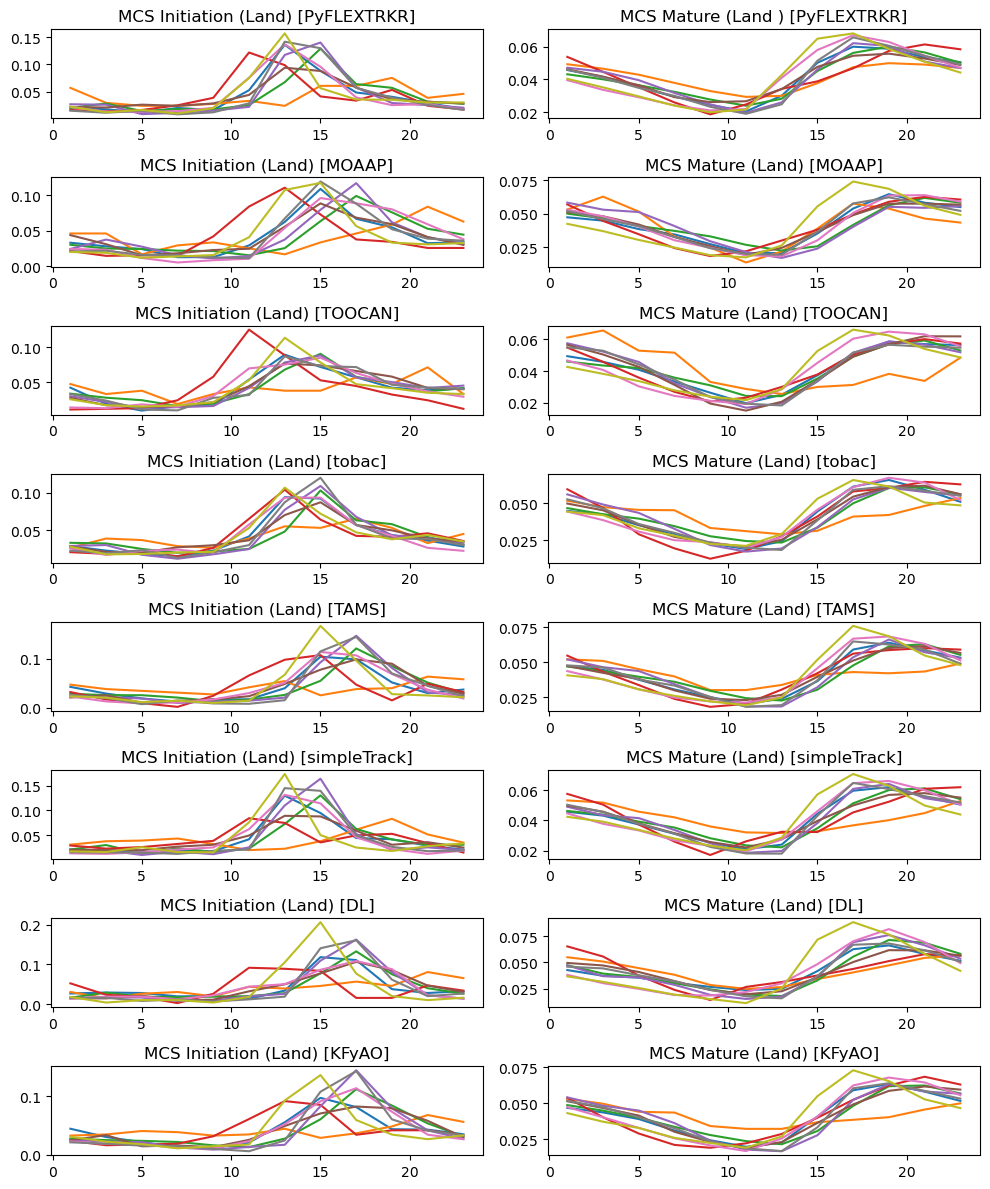

In [96]:
fig, axes = plt.subplots(8, 2, figsize=(10,12), dpi=100)
# PyFLEXTRKR
ax00 = axes[0][0]
for key in name_map:
    ax00.plot(binhour_v, pdf_inithour_pyflex_l[key], label=f'{key}')
    # ax00.legend()
ax01 = axes[0][1]
for key in name_map:
    ax01.plot(binhour_v, pdf_mcshour_pyflex_l[key], label=f'{key}')
    # ax01.legend()
ax00.set_title('MCS Initiation (Land) [PyFLEXTRKR]')
ax01.set_title('MCS Mature (Land ) [PyFLEXTRKR]')
    
# MOAAP
ax10 = axes[1][0]
for key in name_map:
    ax10.plot(binhour_v, pdf_inithour_moaap_l[key], label=f'{key}')
ax11 = axes[1][1]
for key in name_map:
    ax11.plot(binhour_v, pdf_mcshour_moaap_l[key], label=f'{key}')
ax10.set_title('MCS Initiation (Land) [MOAAP]')
ax11.set_title('MCS Mature (Land) [MOAAP]')
    
# TOOCAN
ax20 = axes[2][0]
for key in name_map:
    ax20.plot(binhour_v, pdf_inithour_toocan_l[key], label=f'{key}')
ax21 = axes[2][1]
for key in name_map:
    ax21.plot(binhour_v, pdf_mcshour_toocan_l[key], label=f'{key}')
ax20.set_title('MCS Initiation (Land) [TOOCAN]')
ax21.set_title('MCS Mature (Land) [TOOCAN]')

# tobac
ax30 = axes[3][0]
for key in name_map:
    ax30.plot(binhour_v, pdf_inithour_tobac_l[key], label=f'{key}')
ax31 = axes[3][1]
for key in name_map:
    ax31.plot(binhour_v, pdf_mcshour_tobac_l[key], label=f'{key}')
ax30.set_title('MCS Initiation (Land) [tobac]')
ax31.set_title('MCS Mature (Land) [tobac]')

# tams
ax40 = axes[4][0]
for key in name_map:
    ax40.plot(binhour_v, pdf_inithour_tams_l[key], label=f'{key}')
ax41 = axes[4][1]
for key in name_map:
    ax41.plot(binhour_v, pdf_mcshour_tams_l[key], label=f'{key}')
ax40.set_title('MCS Initiation (Land) [TAMS]')
ax41.set_title('MCS Mature (Land) [TAMS]')

# simpleTrack
ax50 = axes[5][0]
for key in name_map:
    ax50.plot(binhour_v, pdf_inithour_simtrack_l[key], label=f'{key}')
ax51 = axes[5][1]
for key in name_map:
    ax51.plot(binhour_v, pdf_mcshour_simtrack_l[key], label=f'{key}')
ax50.set_title('MCS Initiation (Land) [simpleTrack]')
ax51.set_title('MCS Mature (Land) [simpleTrack]')

# DL
ax60 = axes[6][0]
for key in name_map:
    ax60.plot(binhour_v, pdf_inithour_dl_l[key], label=f'{key}')
ax61 = axes[6][1]
for key in name_map:
    ax61.plot(binhour_v, pdf_mcshour_dl_l[key], label=f'{key}')
ax60.set_title('MCS Initiation (Land) [DL]')
ax61.set_title('MCS Mature (Land) [DL]')

# KFyAO
ax70 = axes[7][0]
for key in name_map:
    ax70.plot(binhour_v, pdf_inithour_kfyao_l[key], label=f'{key}')
ax71 = axes[7][1]
for key in name_map:
    ax71.plot(binhour_v, pdf_mcshour_kfyao_l[key], label=f'{key}')
ax70.set_title('MCS Initiation (Land) [KFyAO]')
ax71.set_title('MCS Mature (Land) [KFyAO]')

fig.tight_layout()

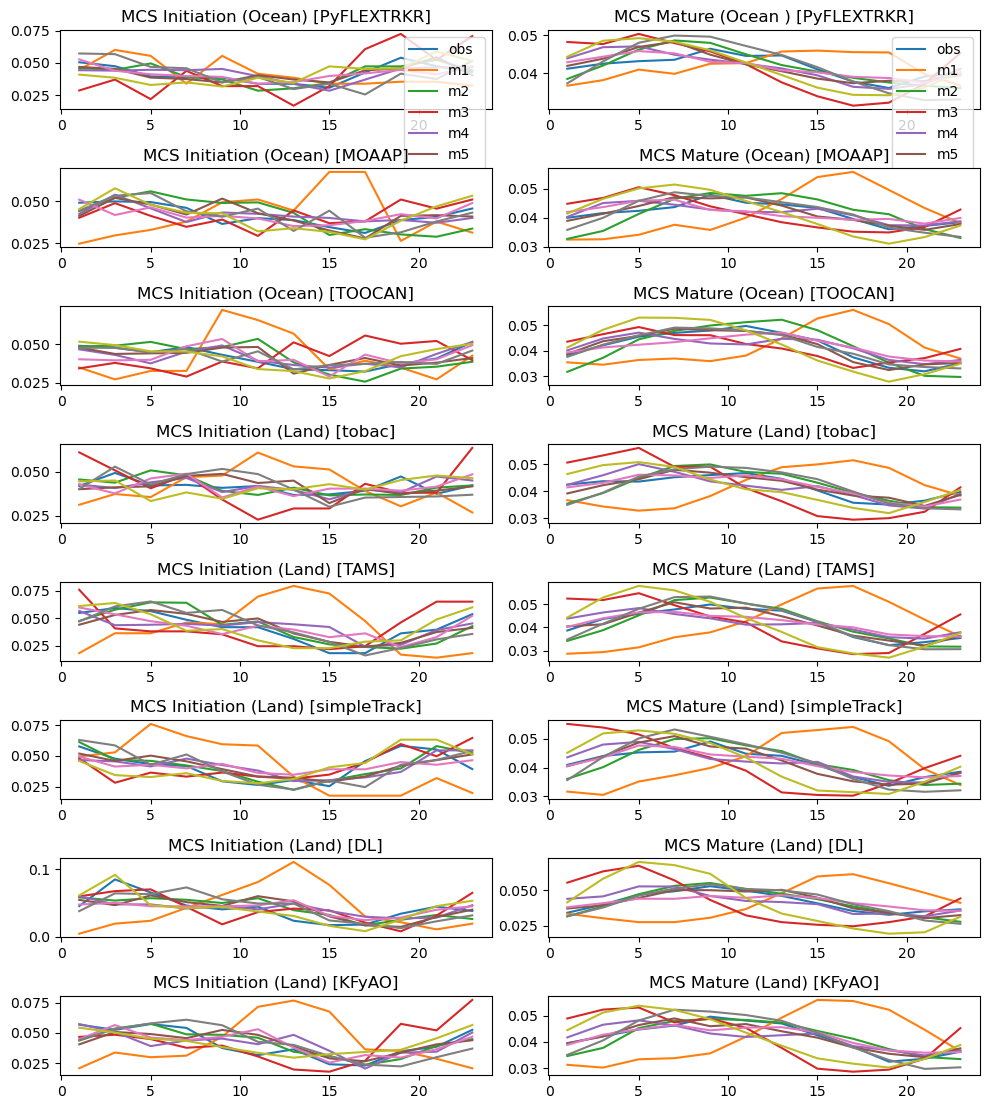

In [97]:
fig, axes = plt.subplots(8, 2, figsize=(10,12), dpi=100)
# PyFLEXTRKR
ax00 = axes[0][0]
for key in name_map:
    ax00.plot(binhour_v, pdf_inithour_pyflex_o[key], label=f'{key}')
    ax00.legend()
ax01 = axes[0][1]
for key in name_map:
    ax01.plot(binhour_v, pdf_mcshour_pyflex_o[key], label=f'{key}')
    ax01.legend()
ax00.set_title('MCS Initiation (Ocean) [PyFLEXTRKR]')
ax01.set_title('MCS Mature (Ocean ) [PyFLEXTRKR]')
    
# MOAAP
ax10 = axes[1][0]
for key in name_map:
    ax10.plot(binhour_v, pdf_inithour_moaap_o[key], label=f'{key}')
ax11 = axes[1][1]
for key in name_map:
    ax11.plot(binhour_v, pdf_mcshour_moaap_o[key], label=f'{key}')
ax10.set_title('MCS Initiation (Ocean) [MOAAP]')
ax11.set_title('MCS Mature (Ocean) [MOAAP]')
    
# TOOCAN
ax20 = axes[2][0]
for key in name_map:
    ax20.plot(binhour_v, pdf_inithour_toocan_o[key], label=f'{key}')
ax21 = axes[2][1]
for key in name_map:
    ax21.plot(binhour_v, pdf_mcshour_toocan_o[key], label=f'{key}')
ax20.set_title('MCS Initiation (Ocean) [TOOCAN]')
ax21.set_title('MCS Mature (Ocean) [TOOCAN]')

# tobac
ax30 = axes[3][0]
for key in name_map:
    ax30.plot(binhour_v, pdf_inithour_tobac_o[key], label=f'{key}')
ax31 = axes[3][1]
for key in name_map:
    ax31.plot(binhour_v, pdf_mcshour_tobac_o[key], label=f'{key}')
ax30.set_title('MCS Initiation (Land) [tobac]')
ax31.set_title('MCS Mature (Land) [tobac]')

# tams
ax40 = axes[4][0]
for key in name_map:
    ax40.plot(binhour_v, pdf_inithour_tams_o[key], label=f'{key}')
ax41 = axes[4][1]
for key in name_map:
    ax41.plot(binhour_v, pdf_mcshour_tams_o[key], label=f'{key}')
ax40.set_title('MCS Initiation (Land) [TAMS]')
ax41.set_title('MCS Mature (Land) [TAMS]')

# simpleTrack
ax50 = axes[5][0]
for key in name_map:
    ax50.plot(binhour_v, pdf_inithour_simtrack_o[key], label=f'{key}')
ax51 = axes[5][1]
for key in name_map:
    ax51.plot(binhour_v, pdf_mcshour_simtrack_o[key], label=f'{key}')
ax50.set_title('MCS Initiation (Land) [simpleTrack]')
ax51.set_title('MCS Mature (Land) [simpleTrack]')

# DL
ax60 = axes[6][0]
for key in name_map:
    ax60.plot(binhour_v, pdf_inithour_dl_o[key], label=f'{key}')
ax61 = axes[6][1]
for key in name_map:
    ax61.plot(binhour_v, pdf_mcshour_dl_o[key], label=f'{key}')
ax60.set_title('MCS Initiation (Land) [DL]')
ax61.set_title('MCS Mature (Land) [DL]')

# KFyAO
ax70 = axes[7][0]
for key in name_map:
    ax70.plot(binhour_v, pdf_inithour_kfyao_o[key], label=f'{key}')
ax71 = axes[7][1]
for key in name_map:
    ax71.plot(binhour_v, pdf_mcshour_kfyao_o[key], label=f'{key}')
ax70.set_title('MCS Initiation (Land) [KFyAO]')
ax71.set_title('MCS Mature (Land) [KFyAO]')

fig.tight_layout()

## Calculate diurnal cycle amplitude and phase

In [98]:
nharm = 8   # Number of harmonics
binsize = 2  # diurnal hour bin size

amp_init_pyflex_l = {}
phs_init_pyflex_l = {}
amp_mat_pyflex_l = {}
phs_mat_pyflex_l = {}
amp_init_pyflex_o = {}
phs_init_pyflex_o = {}
amp_mat_pyflex_o = {}
phs_mat_pyflex_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_pyflex_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_pyflex_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_pyflex_l[key] = amp_init[0]
    phs_init_pyflex_l[key] = phs_init[0]
    amp_mat_pyflex_l[key] = amp_mat[0]
    phs_mat_pyflex_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_pyflex_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_pyflex_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_pyflex_o[key] = amp_init[0]
    phs_init_pyflex_o[key] = phs_init[0]
    amp_mat_pyflex_o[key] = amp_mat[0]
    phs_mat_pyflex_o[key] = phs_mat[0]

In [99]:
amp_init_moaap_l = {}
phs_init_moaap_l = {}
amp_mat_moaap_l = {}
phs_mat_moaap_l = {}
amp_init_moaap_o = {}
phs_init_moaap_o = {}
amp_mat_moaap_o = {}
phs_mat_moaap_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_moaap_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_moaap_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_moaap_l[key] = amp_init[0]
    phs_init_moaap_l[key] = phs_init[0]
    amp_mat_moaap_l[key] = amp_mat[0]
    phs_mat_moaap_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_moaap_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_moaap_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_moaap_o[key] = amp_init[0]
    phs_init_moaap_o[key] = phs_init[0]
    amp_mat_moaap_o[key] = amp_mat[0]
    phs_mat_moaap_o[key] = phs_mat[0]

In [100]:
amp_init_toocan_l = {}
phs_init_toocan_l = {}
amp_mat_toocan_l = {}
phs_mat_toocan_l = {}
amp_init_toocan_o = {}
phs_init_toocan_o = {}
amp_mat_toocan_o = {}
phs_mat_toocan_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_toocan_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_toocan_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_toocan_l[key] = amp_init[0]
    phs_init_toocan_l[key] = phs_init[0]
    amp_mat_toocan_l[key] = amp_mat[0]
    phs_mat_toocan_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_toocan_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_toocan_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_toocan_o[key] = amp_init[0]
    phs_init_toocan_o[key] = phs_init[0]
    amp_mat_toocan_o[key] = amp_mat[0]
    phs_mat_toocan_o[key] = phs_mat[0]

In [101]:
amp_init_tobac_l = {}
phs_init_tobac_l = {}
amp_mat_tobac_l = {}
phs_mat_tobac_l = {}
amp_init_tobac_o = {}
phs_init_tobac_o = {}
amp_mat_tobac_o = {}
phs_mat_tobac_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_tobac_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_tobac_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_tobac_l[key] = amp_init[0]
    phs_init_tobac_l[key] = phs_init[0]
    amp_mat_tobac_l[key] = amp_mat[0]
    phs_mat_tobac_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_tobac_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_tobac_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_tobac_o[key] = amp_init[0]
    phs_init_tobac_o[key] = phs_init[0]
    amp_mat_tobac_o[key] = amp_mat[0]
    phs_mat_tobac_o[key] = phs_mat[0]

In [102]:
amp_init_tams_l = {}
phs_init_tams_l = {}
amp_mat_tams_l = {}
phs_mat_tams_l = {}
amp_init_tams_o = {}
phs_init_tams_o = {}
amp_mat_tams_o = {}
phs_mat_tams_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_tams_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_tams_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_tams_l[key] = amp_init[0]
    phs_init_tams_l[key] = phs_init[0]
    amp_mat_tams_l[key] = amp_mat[0]
    phs_mat_tams_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_tams_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_tams_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_tams_o[key] = amp_init[0]
    phs_init_tams_o[key] = phs_init[0]
    amp_mat_tams_o[key] = amp_mat[0]
    phs_mat_tams_o[key] = phs_mat[0]

In [103]:
amp_init_simtrack_l = {}
phs_init_simtrack_l = {}
amp_mat_simtrack_l = {}
phs_mat_simtrack_l = {}
amp_init_simtrack_o = {}
phs_init_simtrack_o = {}
amp_mat_simtrack_o = {}
phs_mat_simtrack_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_simtrack_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_simtrack_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_simtrack_l[key] = amp_init[0]
    phs_init_simtrack_l[key] = phs_init[0]
    amp_mat_simtrack_l[key] = amp_mat[0]
    phs_mat_simtrack_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_simtrack_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_simtrack_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_simtrack_o[key] = amp_init[0]
    phs_init_simtrack_o[key] = phs_init[0]
    amp_mat_simtrack_o[key] = amp_mat[0]
    phs_mat_simtrack_o[key] = phs_mat[0]

In [104]:
amp_init_dl_l = {}
phs_init_dl_l = {}
amp_mat_dl_l = {}
phs_mat_dl_l = {}
amp_init_dl_o = {}
phs_init_dl_o = {}
amp_mat_dl_o = {}
phs_mat_dl_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_dl_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_dl_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_dl_l[key] = amp_init[0]
    phs_init_dl_l[key] = phs_init[0]
    amp_mat_dl_l[key] = amp_mat[0]
    phs_mat_dl_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_dl_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_dl_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_dl_o[key] = amp_init[0]
    phs_init_dl_o[key] = phs_init[0]
    amp_mat_dl_o[key] = amp_mat[0]
    phs_mat_dl_o[key] = phs_mat[0]

In [105]:
amp_init_kfyao_l = {}
phs_init_kfyao_l = {}
amp_mat_kfyao_l = {}
phs_mat_kfyao_l = {}
amp_init_kfyao_o = {}
phs_init_kfyao_o = {}
amp_mat_kfyao_o = {}
phs_mat_kfyao_o = {}
# Loop over each source
for key in name_map.keys():
    # Land
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_kfyao_l[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_kfyao_l[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_kfyao_l[key] = amp_init[0]
    phs_init_kfyao_l[key] = phs_init[0]
    amp_mat_kfyao_l[key] = amp_mat[0]
    phs_mat_kfyao_l[key] = phs_mat[0]
    
    # Ocean
    amp_init, phs_init, pvar_init = harmonic_phase_amplitude(pdf_inithour_kfyao_o[key], nharm, 0., binsize=binsize)
    amp_mat, phs_mat, pvar_mat = harmonic_phase_amplitude(pdf_mcshour_kfyao_o[key], nharm, 0., binsize=binsize)
    # Save the first harmonic values
    amp_init_kfyao_o[key] = amp_init[0]
    phs_init_kfyao_o[key] = phs_init[0]
    amp_mat_kfyao_o[key] = amp_mat[0]
    phs_mat_kfyao_o[key] = phs_mat[0]

In [106]:
phs_init_pyflex_l, phs_init_moaap_l, phs_init_toocan_l, phs_init_tobac_l, phs_init_tams_l, phs_init_simtrack_l, phs_init_dl_l, phs_init_kfyao_l

({'obs': 13.368136412726598,
  'm1': 18.142889941828773,
  'm2': 14.948291620900655,
  'm3': 11.855182969838893,
  'm4': 14.057595432141165,
  'm5': 13.537814165882732,
  'm6': 12.793382370912225,
  'm7': 13.831343808319486,
  'm12': 12.876159490827769},
 {'obs': 15.491791045816555,
  'm1': 20.462742498429005,
  'm2': 17.46951098978898,
  'm3': 12.452309833704701,
  'm4': 16.689622825637514,
  'm5': 16.069602519448658,
  'm6': 16.7202805740328,
  'm7': 15.612304250939689,
  'm12': 14.059148458144907},
 {'obs': 14.828286464112402,
  'm1': 18.336082697431266,
  'm2': 15.433312708847827,
  'm3': 11.534676113193242,
  'm4': 15.299033485572245,
  'm5': 15.20211870093933,
  'm6': 13.842679267588347,
  'm7': 15.293042583241208,
  'm12': 13.792259609516766},
 {'obs': 14.2684757845638,
  'm1': 15.606596302974978,
  'm2': 15.821280911695851,
  'm3': 13.651853079251831,
  'm4': 15.198558003673849,
  'm5': 14.632247729437386,
  'm6': 13.522767282902006,
  'm7': 14.472908903682882,
  'm12': 13.9337

## Function to plot diurnal cycle for multiple trackers

In [107]:
def plot_diurnal_mxn(nrow, ncol, data_arr, amp_arr, phs_arr, binhour_v, 
                     titles=None, titles_loc=None, title_ha=None, xlabels=None, ylabels=None, xticks=None, legends=None, legend_loc=None, legend_ncol=None, legend_anchor=None,
                     fontsize=None, legend_fontsize=None, ylims=None, amp_scale=None, col_labels=None,
                     map_extent=None, lonbox=None, latbox=None, inset_param=None, figname=None, figsize=None, inset_flag=None):

    mpl.rcParams['font.size'] = fontsize
    mpl.rcParams['font.family'] = 'Helvetica'

    fig = plt.figure(figsize=figsize, dpi=100)
    gs = gridspec.GridSpec(nrow, ncol)
    gs.update(left=0.05, right=0.88, bottom=0.1, top=0.95, wspace=0.20, hspace=0.)
    
    lcolors = {
        'obs':'k', 
        'm1': 'crimson',
        'm2': 'darkorange', 
        'm3': 'gold',
        'm4': 'green',
        'm5': 'turquoise',
        'm6': 'lime',
        'm7': 'blue',
        'm8': 'deepskyblue',
        'm9': 'purple',
        'm10': 'violet',
        'm11': 'deeppink',
        'm12': 'dodgerblue',
    }
    lw = 1.5
    lws = {
        'obs': lw*3, 
        'm1': lw,
        'm2': lw, 
        'm3': lw,
        'm4': lw,
        'm5': lw,
        'm6': lw,
        'm7': lw,
        'm8': lw,
        'm9': lw,
        'm10': lw,
        'm11': lw,
        'm12': lw,
    }
    
    # Loop over column and row
    for col in range(0, ncol):
        for row in range(0, nrow):
            ax = plt.subplot(gs[row,col])
            # Plot title for each column
            xmin, xmax = ax.get_xlim()
            xmid = (xmin + xmax)/2
            if row == 0:
                ax.text(xmid, 1.1, col_labels[col], fontsize=fontsize*1.5, ha='center', transform=ax.transAxes)

            # Share x-axis for all rows in each column
            if row < nrow - 1:
                # ax.get_xaxis().set_visible(False)
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(xlabels[col])
            
            # Plot data
            for key, val in data_arr[row][col].items():
                # ax.plot(binhour_v, data_arr[row][col][key], lcolors[key], lw=lws[key], label=legends[row][col][key])
                ax.plot(binhour_v, data_arr[row][col][key], lcolors[key], lw=lws[key], label=legends[key])
                yspan = (ylims[col][1] - ylims[col][0])
                amp = amp_arr[row][col][key] * amp_scale[col]  # scale the diurnal amplitude
                # Plot diurnal phase and amplitude
                ax.scatter(phs_arr[row][col][key], ylims[col][0]+yspan*0.01, s=15, marker='^', facecolor=lcolors[key])
                ax.axvline(phs_arr[row][col][key], ymax=ylims[col][0]+amp, color=lcolors[key], lw=lws[key])
            ax.grid(which='major', ls='--')
            # ax.set_xlabel(xlabels[row][col])
            ax.set_ylabel(ylabels[row][col])
            ax.set_xticks(xticks)
            ax.set_ylim(ylims[col][0], ylims[col][1])
            # ax.set_title(titles[row][col], loc='left')
            # Make title within the axis
            flabel = ax.text(titles_loc[0], titles_loc[1], titles[row][col], ha=title_ha, transform=ax.transAxes, fontsize=fontsize)
            flabel.set_bbox(dict(facecolor='w', alpha=0.8, edgecolor='w'))
            # ax.legend(fontsize=legend_fontsize, loc=legend_loc[row][col], ncol=legend_ncol[row][col])
            if (row == 0) & (col == ncol-1):
                ax.legend(fontsize=legend_fontsize, loc=legend_loc, ncol=legend_ncol, bbox_to_anchor=legend_anchor)

    fig.savefig(figname, dpi=300, facecolor='w', bbox_inches='tight')
    return fig

In [108]:
# init_legend_pyflex_l = {}
# init_legend_moaap_l = {}
# init_legend_toocan_l = {}
# init_legend_tobac_l = {}
# init_legend_tams_l = {}
# init_legend_simtrack_l = {}
# init_legend_dl_l = {}
# init_legend_kfyao_l = {}

# mat_legend_pyflex_l = {}
# mat_legend_moaap_l = {}
# mat_legend_toocan_l = {}
# mat_legend_tobac_l = {}
# mat_legend_tams_l = {}
# mat_legend_simtrack_l = {}
# mat_legend_dl_l = {}
# mat_legend_kfyao_l = {}

# init_legend_pyflex_o = {}
# init_legend_moaap_o = {}
# init_legend_toocan_o = {}
# init_legend_tobac_o = {}
# init_legend_tams_o = {}
# init_legend_simtrack_o = {}
# init_legend_dl_o = {}
# init_legend_kfyao_o = {}

# mat_legend_pyflex_o = {}
# mat_legend_moaap_o = {}
# mat_legend_toocan_o = {}
# mat_legend_tobac_o = {}
# mat_legend_tams_o = {}
# mat_legend_simtrack_o = {}
# mat_legend_dl_o = {}
# mat_legend_kfyao_o = {}

# for key in name_map:
#     # Initiation
#     init_legend_pyflex_l[key] = f"{name_map[key]} ({amp_init_pyflex_l[key]:.03f}, {phs_init_pyflex_l[key]:2.1f} h)"
#     init_legend_moaap_l[key] = f"{name_map[key]} ({amp_init_moaap_l[key]:.03f}, {phs_init_moaap_l[key]:2.1f} h)"
#     init_legend_toocan_l[key] = f"{name_map[key]} ({amp_init_toocan_l[key]:.03f}, {phs_init_toocan_l[key]:2.1f} h)"
#     init_legend_tobac_l[key] = f"{name_map[key]} ({amp_init_tobac_l[key]:.03f}, {phs_init_tobac_l[key]:2.1f} h)"
#     init_legend_tams_l[key] = f"{name_map[key]} ({amp_init_tams_l[key]:.03f}, {phs_init_tams_l[key]:2.1f} h)"
#     init_legend_simtrack_l[key] = f"{name_map[key]} ({amp_init_simtrack_l[key]:.03f}, {phs_init_simtrack_l[key]:2.1f} h)"
#     init_legend_dl_l[key] = f"{name_map[key]} ({amp_init_dl_l[key]:.03f}, {phs_init_dl_l[key]:2.1f} h)"
#     init_legend_kfyao_l[key] = f"{name_map[key]} ({amp_init_kfyao_l[key]:.03f}, {phs_init_kfyao_l[key]:2.1f} h)"

#     # Mature
#     mat_legend_pyflex_l[key] = f"{name_map[key]} ({amp_mat_pyflex_l[key]:.03f}, {phs_mat_pyflex_l[key]:2.1f} h)"
#     mat_legend_moaap_l[key] = f"{name_map[key]} ({amp_mat_moaap_l[key]:.03f}, {phs_mat_moaap_l[key]:2.1f} h)"
#     mat_legend_toocan_l[key] = f"{name_map[key]} ({amp_mat_toocan_l[key]:.03f}, {phs_mat_toocan_l[key]:2.1f} h)"
#     mat_legend_tobac_l[key] = f"{name_map[key]} ({amp_mat_tobac_l[key]:.03f}, {phs_mat_tobac_l[key]:2.1f} h)"
#     mat_legend_tams_l[key] = f"{name_map[key]} ({amp_mat_tams_l[key]:.03f}, {phs_mat_tams_l[key]:2.1f} h)"
#     mat_legend_simtrack_l[key] = f"{name_map[key]} ({amp_mat_simtrack_l[key]:.03f}, {phs_mat_simtrack_l[key]:2.1f} h)"
#     mat_legend_dl_l[key] = f"{name_map[key]} ({amp_mat_dl_l[key]:.03f}, {phs_mat_dl_l[key]:2.1f} h)"
#     mat_legend_kfyao_l[key] = f"{name_map[key]} ({amp_mat_kfyao_l[key]:.03f}, {phs_mat_kfyao_l[key]:2.1f} h)"
    
#     # Initiation
#     init_legend_pyflex_o[key] = f"{name_map[key]} ({amp_init_pyflex_o[key]:.03f}, {phs_init_pyflex_o[key]:2.1f} h)"
#     init_legend_moaap_o[key] = f"{name_map[key]} ({amp_init_moaap_o[key]:.03f}, {phs_init_moaap_o[key]:2.1f} h)"
#     init_legend_toocan_o[key] = f"{name_map[key]} ({amp_init_toocan_o[key]:.03f}, {phs_init_toocan_o[key]:2.1f} h)"
#     init_legend_tobac_o[key] = f"{name_map[key]} ({amp_init_tobac_o[key]:.03f}, {phs_init_tobac_o[key]:2.1f} h)"
#     init_legend_tams_o[key] = f"{name_map[key]} ({amp_init_tams_o[key]:.03f}, {phs_init_tams_o[key]:2.1f} h)"
#     init_legend_simtrack_o[key] = f"{name_map[key]} ({amp_init_simtrack_o[key]:.03f}, {phs_init_simtrack_o[key]:2.1f} h)"
#     init_legend_dl_o[key] = f"{name_map[key]} ({amp_init_dl_o[key]:.03f}, {phs_init_dl_o[key]:2.1f} h)"
#     init_legend_kfyao_o[key] = f"{name_map[key]} ({amp_init_kfyao_o[key]:.03f}, {phs_init_kfyao_o[key]:2.1f} h)"
    
#     # Mature
#     mat_legend_pyflex_o[key] = f"{name_map[key]} ({amp_mat_pyflex_o[key]:.03f}, {phs_mat_pyflex_o[key]:2.1f} h)"
#     mat_legend_moaap_o[key] = f"{name_map[key]} ({amp_mat_moaap_o[key]:.03f}, {phs_mat_moaap_o[key]:2.1f} h)"
#     mat_legend_toocan_o[key] = f"{name_map[key]} ({amp_mat_toocan_o[key]:.03f}, {phs_mat_toocan_o[key]:2.1f} h)"
#     mat_legend_tobac_o[key] = f"{name_map[key]} ({amp_mat_tobac_o[key]:.03f}, {phs_mat_tobac_o[key]:2.1f} h)"
#     mat_legend_tams_o[key] = f"{name_map[key]} ({amp_mat_tams_o[key]:.03f}, {phs_mat_tams_o[key]:2.1f} h)"
#     mat_legend_simtrack_o[key] = f"{name_map[key]} ({amp_mat_simtrack_o[key]:.03f}, {phs_mat_simtrack_o[key]:2.1f} h)"
#     mat_legend_dl_o[key] = f"{name_map[key]} ({amp_mat_dl_o[key]:.03f}, {phs_mat_dl_o[key]:2.1f} h)"
#     mat_legend_kfyao_o[key] = f"{name_map[key]} ({amp_mat_kfyao_o[key]:.03f}, {phs_mat_kfyao_o[key]:2.1f} h)"

In [109]:
if PHASE == 'Summer':
    panel_numbers = ['(a)', '(b)', ]
elif PHASE == 'Winter':
    panel_numbers = ['(c)', '(d)', ]
print(panel_numbers)

['(a)', '(b)']


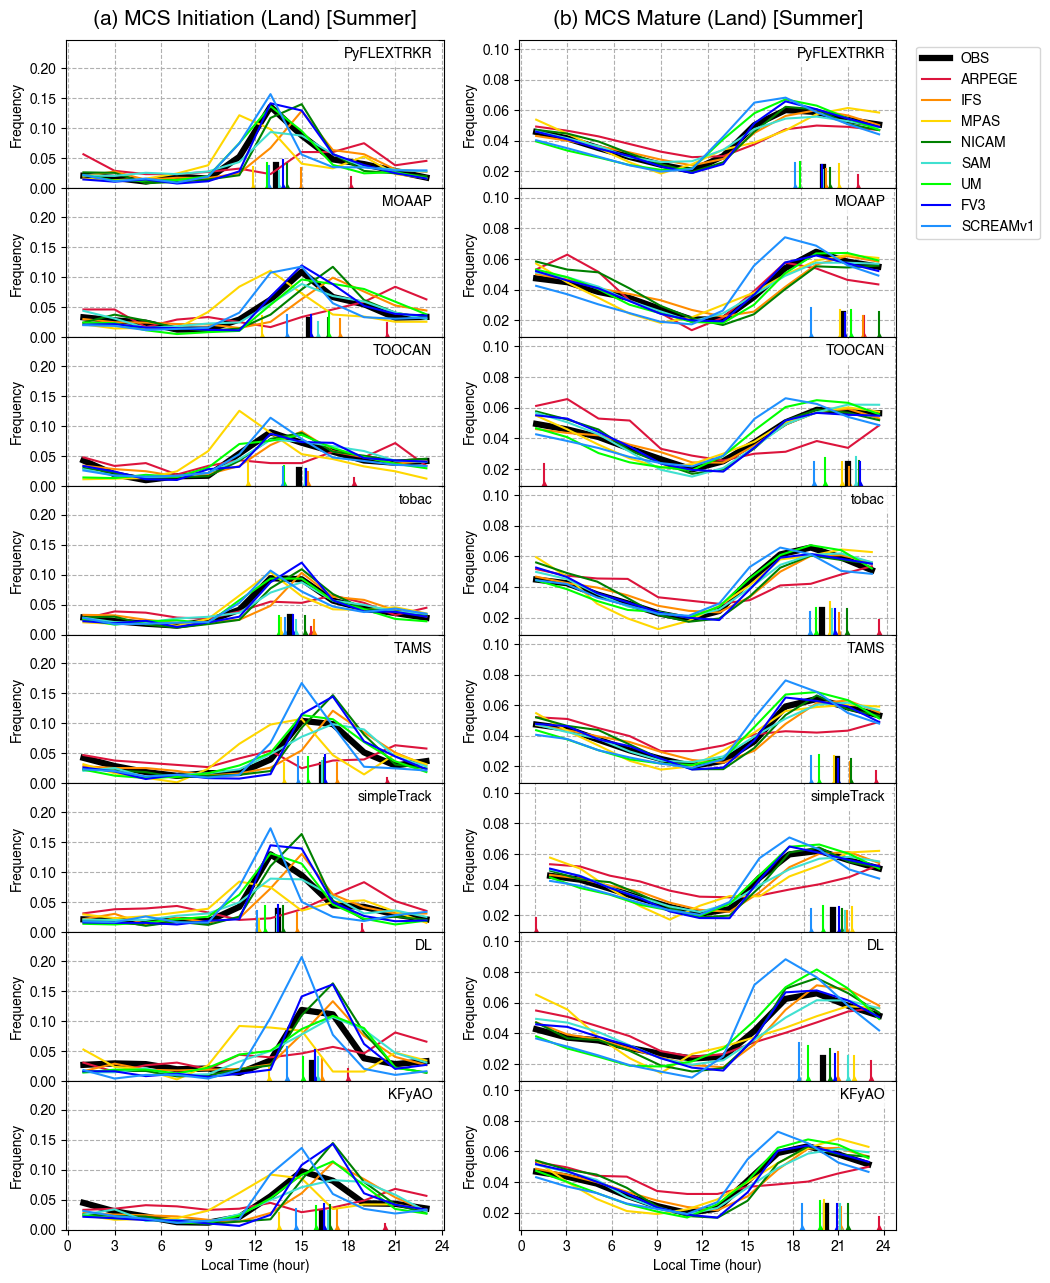

In [110]:
# Data array [row][col]
data_arr = [
    [pdf_inithour_pyflex_l, pdf_mcshour_pyflex_l],
    [pdf_inithour_moaap_l, pdf_mcshour_moaap_l],
    [pdf_inithour_toocan_l, pdf_mcshour_toocan_l],
    [pdf_inithour_tobac_l, pdf_mcshour_tobac_l],
    [pdf_inithour_tams_l, pdf_mcshour_tams_l],
    [pdf_inithour_simtrack_l, pdf_mcshour_simtrack_l],
    [pdf_inithour_dl_l, pdf_mcshour_dl_l],
    [pdf_inithour_kfyao_l, pdf_mcshour_kfyao_l],
]
amp_arr = [
    [amp_init_pyflex_l, amp_mat_pyflex_l],
    [amp_init_moaap_l, amp_mat_moaap_l],
    [amp_init_toocan_l, amp_mat_toocan_l],
    [amp_init_tobac_l, amp_mat_tobac_l],
    [amp_init_tams_l, amp_mat_tams_l],
    [amp_init_simtrack_l, amp_mat_simtrack_l],
    [amp_init_dl_l, amp_mat_dl_l],
    [amp_init_kfyao_l, amp_mat_kfyao_l],
]
phs_arr = [
    [phs_init_pyflex_l, phs_mat_pyflex_l],
    [phs_init_moaap_l, phs_mat_moaap_l],
    [phs_init_toocan_l, phs_mat_toocan_l],
    [phs_init_tobac_l, phs_mat_tobac_l],
    [phs_init_tams_l, phs_mat_tams_l],
    [phs_init_simtrack_l, phs_mat_simtrack_l],
    [phs_init_dl_l, phs_mat_dl_l],
    [phs_init_kfyao_l, phs_mat_kfyao_l],
]
# legends = [
#     [init_legend_pyflex_l, mat_legend_pyflex_l],
#     [init_legend_moaap_l, mat_legend_moaap_l],
#     [init_legend_toocan_l, mat_legend_toocan_l],
#     [init_legend_tobac_l, mat_legend_tobac_l],
#     [init_legend_tams_l, mat_legend_tams_l],
#     [init_legend_simtrack_l, mat_legend_simtrack_l],
#     [init_legend_dl_l, mat_legend_dl_l],
#     [init_legend_kfyao_l, mat_legend_kfyao_l],
# ]
legends = name_map
nrow = len(data_arr)
col_labels = [f'{panel_numbers[0]} MCS Initiation (Land) [{PHASE}]', f'{panel_numbers[1]} MCS Mature (Land) [{PHASE}]']
titles = [
    ['PyFLEXTRKR', 'PyFLEXTRKR',],
    ['MOAAP', 'MOAAP',],
    ['TOOCAN', 'TOOCAN',],
    ['tobac', 'tobac',],
    ['TAMS', 'TAMS'],
    ['simpleTrack', 'simpleTrack'],
    ['DL', 'DL'],
    ['KFyAO', 'KFyAO'],
]
titles_loc = [0.97, 0.88]
title_ha = 'right'
xlabels = ['Local Time (hour)','Local Time (hour)']
ylabels = [['Frequency', 'Frequency']] * nrow
xticks = np.arange(0,25,3)
# ylims = [(0.0,0.18),(0.01,0.09)]
ylims = [(0, minmax_inithour_l[1]*1.2), (minmax_mcshour_l[0]*0.8, minmax_mcshour_l[1]*1.2)]
amp_scale = [4, 8]
# legend_loc = [['upper left','upper left']] * nrow
# legend_ncol = [[1,2]] * nrow
legend_loc = 'upper right'
legend_anchor = (1.4, 1)
legend_ncol = 1
fontsize = 10
legend_fontsize = 10
# figsize = [10,12]
# figsize = [10,13]
figsize = [10,14]
figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_land_all.png'
fig = plot_diurnal_mxn(nrow, 2, data_arr, amp_arr, phs_arr, binhour_v, 
                       titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol, legend_anchor=legend_anchor,
                       fontsize=fontsize, legend_fontsize=legend_fontsize, ylims=ylims, amp_scale=amp_scale, col_labels=col_labels,
                       figname=figname, figsize=figsize)

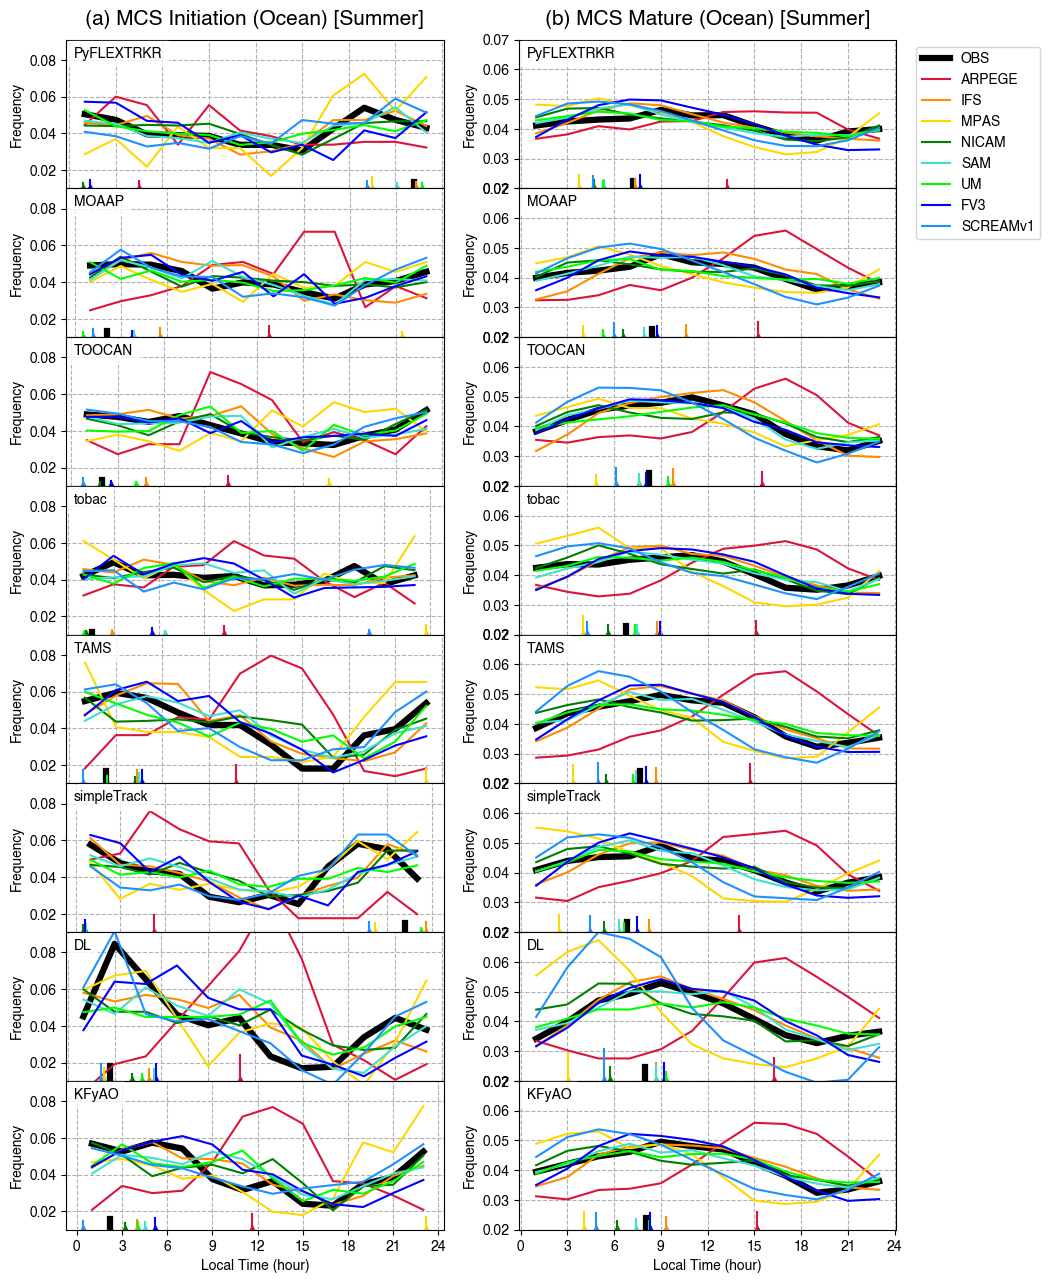

In [111]:
# Data array [row][col]
data_arr = [
    [pdf_inithour_pyflex_o, pdf_mcshour_pyflex_o],
    [pdf_inithour_moaap_o, pdf_mcshour_moaap_o],
    [pdf_inithour_toocan_o, pdf_mcshour_toocan_o],
    [pdf_inithour_tobac_o, pdf_mcshour_tobac_o],
    [pdf_inithour_tams_o, pdf_mcshour_tams_o],
    [pdf_inithour_simtrack_o, pdf_mcshour_simtrack_o],
    [pdf_inithour_dl_o, pdf_mcshour_dl_o],
    [pdf_inithour_kfyao_o, pdf_mcshour_kfyao_o],
]
amp_arr = [
    [amp_init_pyflex_o, amp_mat_pyflex_o],
    [amp_init_moaap_o, amp_mat_moaap_o],
    [amp_init_toocan_o, amp_mat_toocan_o],
    [amp_init_tobac_o, amp_mat_tobac_o],
    [amp_init_tams_o, amp_mat_tams_o],
    [amp_init_simtrack_o, amp_mat_simtrack_o],
    [amp_init_dl_o, amp_mat_dl_o],
    [amp_init_kfyao_o, amp_mat_kfyao_o],
]
phs_arr = [
    [phs_init_pyflex_o, phs_mat_pyflex_o],
    [phs_init_moaap_o, phs_mat_moaap_o],
    [phs_init_toocan_o, phs_mat_toocan_o],
    [phs_init_tobac_o, phs_mat_tobac_o],
    [phs_init_tams_o, phs_mat_tams_o],
    [phs_init_simtrack_o, phs_mat_simtrack_o],
    [phs_init_dl_o, phs_mat_dl_o],
    [phs_init_kfyao_o, phs_mat_kfyao_o],
]
# legends = [
#     [init_legend_pyflex_o, mat_legend_pyflex_o],
#     [init_legend_moaap_o, mat_legend_moaap_o],
#     [init_legend_toocan_o, mat_legend_toocan_o],
#     [init_legend_tobac_o, mat_legend_tobac_o],
#     [init_legend_tams_o, mat_legend_tams_o],
#     [init_legend_simtrack_o, mat_legend_simtrack_o],
#     [init_legend_dl_o, mat_legend_dl_o],
#     [init_legend_kfyao_o, mat_legend_kfyao_o],
# ]
legends = name_map
nrow = len(data_arr)
col_labels = [f'{panel_numbers[0]} MCS Initiation (Ocean) [{PHASE}]', f'{panel_numbers[1]} MCS Mature (Ocean) [{PHASE}]']
titles = [
    ['PyFLEXTRKR', 'PyFLEXTRKR',],
    ['MOAAP', 'MOAAP',],
    ['TOOCAN', 'TOOCAN',],
    ['tobac', 'tobac',],
    ['TAMS', 'TAMS'],
    ['simpleTrack', 'simpleTrack'],
    ['DL', 'DL'],
    ['KFyAO', 'KFyAO'],
]
titles_loc = [0.02, 0.88]
title_ha = 'left'
xlabels = ['Local Time (hour)','Local Time (hour)']
ylabels = [['Frequency', 'Frequency']] * nrow
xticks = np.arange(0,25,3)
# ylims = [(0.02,0.08),(0.025,0.065)]
ylims = [(minmax_inithour_o[0]*0.8, minmax_inithour_o[1]*1.2), (minmax_mcshour_o[0]*0.8, minmax_mcshour_o[1]*1.2)]
# ylims = [(minmax_inithour_o[0]*0.9, minmax_inithour_o[1]*1.1), (minmax_mcshour_o[0]*0.9, minmax_mcshour_o[1]*1.1)]
ylims = [(0.01,0.091),(0.02,0.07)]
amp_scale = [4, 8]

# legend_loc = [['upper right','upper right']] * nrow
# legend_ncol = [[2,2]] * nrow
legend_loc = 'upper right'
legend_anchor = (1.4, 1)
legend_ncol = 1
fontsize = 10
legend_fontsize = 10
# figsize = [10,12]
# figsize = [10,13]
figsize = [10,14]
figname = f'{figdir}mcs_initiation_mature_time_diurnal_cycle_ocean_all.png'
fig = plot_diurnal_mxn(nrow, 2, data_arr, amp_arr, phs_arr, binhour_v, 
                       titles=titles, titles_loc=titles_loc, title_ha=title_ha, xlabels=xlabels, ylabels=ylabels, xticks=xticks, legends=legends, legend_loc=legend_loc, legend_ncol=legend_ncol, legend_anchor=legend_anchor,
                       fontsize=fontsize, legend_fontsize=legend_fontsize, ylims=ylims, amp_scale=amp_scale, col_labels=col_labels,
                       figname=figname, figsize=figsize)

In [112]:
figname

'/global/cfs/cdirs/m1867/zfeng/MCSMIP/DYAMOND/Summer/figures/MCSMIP/mcs_initiation_mature_time_diurnal_cycle_ocean_all.png'